# Домашнее задание №1

В этом домашнем задании вам предлагается обучить модель регрессии для предсказания стоимости автомобилей, а также реализовать веб-сервис для применения построенной модели на новых данных.

> Оценка за домашку = min(ваш балл, 10)


Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода.

А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

In [1]:
import random
import warnings
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, RobustScaler

random.seed(42)
np.random.seed(42)

/home/proven_warrior/hse/intro_to_ml/homework_1/mlvenv/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.simplefilter("ignore", category=FutureWarning)

Ниже ответьте на вопрос <font color='#FF6600'>
"Для чего фиксируем сиды в домашках?"</font>

Фиксируем сиды для того, чтобы более-менее (фиксация все равно не дает 100% гарантии повторения) был детерминированный результат работы функций, где задействуется (рандом разделение выборок - основное).
Это дает возможность в последующем запустить ноутбук и получить те же результаты, то есть получить воспроизводимость результата.

# Часть 1 (2.5 балла + 0.75) | EDA

## Простейший EDA и обработка признаков (1.5 балла + 0.25)

In [3]:
df_train = pd.read_csv(
    "https://raw.githubusercontent.com/"
    "Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv"
)
df_test = pd.read_csv(
    "https://raw.githubusercontent.com/"
    "Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv"
)

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


(0.15 балла) <font color='#9933CC'>Отобразите 10 **случайных** строк тренировочного датасета</font>

In [4]:
df_train.sample(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
6565,Renault KWID Climber 1.0 MT BSIV,2019,300000,35000,Petrol,Individual,Manual,First Owner,23.01 kmpl,999 CC,67 bhp,91Nm@ 4250rpm,5.0
2943,Maruti Wagon R LXI,2013,225000,58343,Petrol,Trustmark Dealer,Manual,First Owner,21.79 kmpl,998 CC,67.05 bhp,90Nm@ 3500rpm,5.0
2024,Hyundai i20 Asta 1.2,2013,360000,30000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
263,Hyundai i20 1.2 Asta,2010,300000,70000,Petrol,Individual,Manual,First Owner,17.0 kmpl,1197 CC,80 bhp,"11.4 kgm at 4,000 rpm",5.0
4586,Skoda Octavia L and K 1.9 TDI MT,2005,250000,120000,Diesel,Individual,Manual,Third Owner,16.4 kmpl,1896 CC,90 bhp,"21.4@ 1,900(kgm@ rpm)",5.0
4479,Maruti Ciaz ZXi,2016,700000,20000,Petrol,Individual,Manual,First Owner,20.73 kmpl,1373 CC,91.1 bhp,130Nm@ 4000rpm,5.0
4881,Hyundai Grand i10 1.2 Kappa Magna BSIV,2017,445000,27000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
3583,Ford Ecosport 1.5 DV5 MT Trend,2016,515000,68609,Diesel,Dealer,Manual,First Owner,22.7 kmpl,1498 CC,89.84 bhp,204Nm@ 2000-2750rpm,5.0
6361,Hyundai Verna 1.4 VTVT,2014,500000,33400,Petrol,Individual,Manual,First Owner,17.43 kmpl,1396 CC,105.5 bhp,135.3Nm@ 5000rpm,5.0
4108,Hyundai i20 Era 1.2,2015,490000,45900,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0


(0.1 балла) <font color='#9933CC'>Отобразите первые 5 и последние 5 объектов тестового датасета</font>

In [5]:
df_test.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0 kmpl,2498 CC,112 bhp,260 Nm at 1800-2200 rpm,7.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9 kmpl,1799 CC,130 bhp,172Nm@ 4300rpm,5.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5 kmpl,1172 CC,65 bhp,96 Nm at 3000 rpm,5.0


In [6]:
df_test.tail(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
995,Hyundai i10 Magna 1.1L,2008,250000,100000,Petrol,Individual,Manual,Second Owner,19.81 kmpl,1086 CC,68.05 bhp,99.04Nm@ 4500rpm,5.0
996,Hyundai i20 2015-2017 Sportz 1.2,2017,440000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0
997,Hyundai i20 Era Diesel,2009,340000,40000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
998,Hyundai i10 Asta,2012,350000,25000,Petrol,Individual,Manual,First Owner,20.36 kmpl,1197 CC,78.9 bhp,111.8Nm@ 4000rpm,5.0
999,Honda City i DTec SV,2016,700000,110000,Diesel,Individual,Manual,First Owner,26.0 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0


(0.1 балла) <font color='#9933CC'>Посчитайте основные статистики как по числовым, так и по категориальным столбцам для трейна и теста</font>. 
> Подсказка: ``.describe()`` с нужным(и) аргументом(-ами)



In [7]:
print("Статистики обучающей выборки по числовым столбцам: ")
df_train.describe().round(2)

Статистики обучающей выборки по числовым столбцам: 


,year,selling_price,km_driven,seats
count,6999.00,6999.00,6999.00,6797.00
mean,2013.82,639515.20,69584.62,5.42
std,4.05,808941.91,57724.00,0.97
min,1983.00,29999.00,1.00,2.00
25%,2011.00,254999.00,35000.00,5.00
50%,2015.00,450000.00,60000.00,5.00
75%,2017.00,675000.00,97000.00,5.00
max,2020.00,10000000.00,2360457.00,14.00


In [8]:
print("Статистики обучающей выборки по категориальным столбцам: ")
df_train.describe(include=["object"])

Статистики обучающей выборки по категориальным столбцам: 


,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,6999,6999,6999,6999,6999,6797,6797,6803,6796
unique,1924,4,3,2,5,386,120,316,419
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm
freq,116,3793,5826,6095,4587,197,885,330,468


In [9]:
print("Статистики тестовой выборки по числовым столбцам: ")
df_test.describe().round(2)

Статистики тестовой выборки по числовым столбцам: 


,year,selling_price,km_driven,seats
count,1000.00,1000.00,1000.00,981.00
mean,2013.68,617901.04,71393.34,5.41
std,4.01,758553.86,48486.22,0.92
min,1995.00,31000.00,1303.00,4.00
25%,2011.00,250000.00,37000.00,5.00
50%,2014.00,434999.00,61500.00,5.00
75%,2017.00,670000.00,100000.00,5.00
max,2020.00,6000000.00,375000.00,9.00


In [10]:
print("Статистики тестовой выборки по категориальным столбцам: ")
df_test.describe(include=["object"])

Статистики тестовой выборки по категориальным столбцам: 


,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,1000,1000,1000,1000,1000,981,981,981,981
unique,621,4,3,2,5,237,88,182,226
top,Maruti Alto 800 LXI,Diesel,Individual,Manual,First Owner,18.6 kmpl,1248 CC,74 bhp,200Nm@ 1750rpm
freq,15,534,837,877,623,23,116,43,57


(0.15 балла) <font color='#9933CC'>Посмотрите, есть ли в датасете пропуски.</font>

<font color='#FF6600'>Если есть, то в каких колонках?</font>

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   object 
 10  max_power      6803 non-null   object 
 11  torque         6796 non-null   object 
 12  seats          6797 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 711.0+ KB


В обучающем датасете есть несколько колонок с пропусками: это _mileage_, _engine_, _max_power_, _torque_, _seats_.

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           1000 non-null   object 
 1   year           1000 non-null   int64  
 2   selling_price  1000 non-null   int64  
 3   km_driven      1000 non-null   int64  
 4   fuel           1000 non-null   object 
 5   seller_type    1000 non-null   object 
 6   transmission   1000 non-null   object 
 7   owner          1000 non-null   object 
 8   mileage        981 non-null    object 
 9   engine         981 non-null    object 
 10  max_power      981 non-null    object 
 11  torque         981 non-null    object 
 12  seats          981 non-null    float64
dtypes: float64(1), int64(3), object(9)
memory usage: 101.7+ KB


В тестовом датасете такая же ситуация.

(0.1 балла) <font color='#9933CC'>Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием</font> (целевую переменную следует исключить). Если есть, то сколько?

In [13]:
df_train_duplicates = df_train.drop(columns="selling_price")
print("Количество объектов с одинаковым признаковым описанием в ", end="")
print(
    "обучающей выборке: ",
    df_train_duplicates[df_train_duplicates.duplicated()].count()[0],
)

Количество объектов с одинаковым признаковым описанием в обучающей выборке:  1159


(0.15 балла) <font color='#9933CC'>Отобразите такие объекты</font>

In [14]:
df_train_duplicates[df_train_duplicates.duplicated()]

,name,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
254,Hyundai Grand i10 Sportz,2017,35000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0
258,Maruti Swift VXI,2012,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,85.8 bhp,114Nm@ 4000rpm,5.0
268,Maruti Swift Dzire VXI,2014,70000,Petrol,Individual,Manual,Second Owner,19.1 kmpl,1197 CC,85.8 bhp,114Nm@ 4000rpm,5.0
324,Jaguar XE 2016-2019 2.0L Diesel Prestige,2017,9000,Diesel,Dealer,Automatic,First Owner,13.6 kmpl,1999 CC,177 bhp,430Nm@ 1750-2500rpm,5.0
325,Lexus ES 300h,2019,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56 bhp,202Nm@ 3600-5200rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6947,Chevrolet Spark 1.0 LS,2010,60000,Petrol,Individual,Manual,Second Owner,18.0 kmpl,995 CC,62 bhp,90.3Nm@ 4200rpm,5.0
6984,Ford Freestyle Titanium Plus Diesel BSIV,2018,24000,Diesel,Individual,Manual,First Owner,24.4 kmpl,1498 CC,98.63 bhp,215Nm@ 1750-3000rpm,5.0
6989,Maruti Swift Dzire VDI,2015,50000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
6997,Tata Indigo CR4,2013,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


(0.15 балла) <font color='#9933CC'>Удалите повторяющиеся строки</font>. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю

In [15]:
df_train = df_train.drop_duplicates(
    subset=df_train.columns.difference(["selling_price"]), keep="first"
)

In [16]:
assert df_train.shape == (5840, 13)

(0.1 балла) Чтоб все было по красоте, <font color='#9933CC'>обновите индексы строк таким образом, чтобы они шли от 0 без пропусков</font>

In [17]:
df_train = df_train.reset_index(drop=True)
df_train.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0


Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не слава богу. Давайте починим.

(0.25 балла) Задача такая: 
<font color='#9933CC'>
* убрать единицы измерения для признаков ``mileage, engine, max_power``. 
* кастануть эти столбцы к ``float``.
* удалить столбец ``torque``
</font>

> Все действия нужно производить над обоими датасетами

---
**Доп (0.25 балла):**
* <font color='#9933CC'>Вместо удаления признак `torque` разделите на два: собственно `torque` и `max_torque_rpm`.</font> Учтите единицы измерения. Они разные ☹

__mileage__

In [18]:
df_train.loc[:, "mileage"] = (
    df_train["mileage"].astype("str").str.extract(r"(\d+.\d+)").astype("float")[0]
)
df_test.loc[:, "mileage"] = (
    df_test["mileage"].astype("str").str.extract(r"(\d+.\d+)").astype("float")[0]
)

In [19]:
df_train["mileage"].head(5)

0    23.40
1    21.14
2    23.00
3    16.10
4    20.14
Name: mileage, dtype: float64

In [20]:
df_test["mileage"].head(5)

0    14.0
1    21.5
2    12.9
3    25.1
4    16.5
Name: mileage, dtype: float64

__engine__

In [21]:
df_train.loc[:, "engine"] = (
    df_train["engine"].astype("str").str.extract(r"(\d+)")[0].astype("float")
)
df_test.loc[:, "engine"] = (
    df_test["engine"].astype("str").str.extract(r"(\d+)")[0].astype("float")
)

In [22]:
df_train["engine"].head(5)

0    1248.0
1    1498.0
2    1396.0
3    1298.0
4    1197.0
Name: engine, dtype: float64

In [23]:
df_test["engine"].head(5)

0    2498.0
1    1497.0
2    1799.0
3    1498.0
4    1172.0
Name: engine, dtype: float64

__max_power__

In [24]:
df_train.loc[:, "max_power"] = (
    df_train["max_power"].astype("str").str.extract(r"([\d\.]+)")[0].astype("float")
)
df_test.loc[:, "max_power"] = (
    df_test["max_power"].astype("str").str.extract(r"([\d\.]+)")[0].astype("float")
)

In [25]:
df_train["max_power"].head(5)

0     74.00
1    103.52
2     90.00
3     88.20
4     81.86
Name: max_power, dtype: float64

In [26]:
df_test["max_power"].head(5)

0    112.0
1    108.5
2    130.0
3     98.6
4     65.0
Name: max_power, dtype: float64

__torque__

In [27]:
def replace_torque_for_kgm(df_with_kgm_torque: pd.Series) -> pd.DataFrame:
    df_with_kgm_torque = df_with_kgm_torque.str.extractall(r"([\d\.,-]+)").reset_index(
        level=1
    )
    df_with_kgm_torque["torque"] = df_with_kgm_torque[df_with_kgm_torque["match"] == 0][
        0
    ]
    df_with_kgm_torque["max_torque_rpm"] = df_with_kgm_torque[
        df_with_kgm_torque["match"] == 1
    ][0]

    df_with_kgm_torque = df_with_kgm_torque.drop(columns=["match", 0])
    df_with_kgm_torque = df_with_kgm_torque.reset_index()
    df_with_kgm_torque = df_with_kgm_torque.drop_duplicates(subset="index")
    df_with_kgm_torque.index = df_with_kgm_torque["index"]
    df_with_kgm_torque.index.name = None
    df_with_kgm_torque = df_with_kgm_torque.drop(columns="index")

    df_with_kgm_torque.loc[:, "torque"] = (
        df_with_kgm_torque["torque"].astype("float") * 9.8
    )
    df_with_kgm_torque.loc[:, "max_torque_rpm"] = (
        df_with_kgm_torque["max_torque_rpm"]
        .apply(
            lambda x: x.split("-")[1].replace(",", "")
            if str(x).find("-") != -1
            else str(x).replace(",", "")
        )
        .astype("float")
    )

    return df_with_kgm_torque

In [28]:
def replace_torque_for_nm(df_with_nm_torque: pd.Series) -> pd.DataFrame:
    df_with_nm_torque = df_with_nm_torque.str.extractall(r"([\d\.,-]+)").reset_index(
        level=1
    )
    df_with_nm_torque["torque"] = df_with_nm_torque[df_with_nm_torque["match"] == 0][0]
    df_with_nm_torque["max_torque_rpm"] = df_with_nm_torque[
        df_with_nm_torque["match"] == 1
    ][0]

    df_with_nm_torque = df_with_nm_torque.drop(columns=["match", 0])
    df_with_nm_torque = df_with_nm_torque.reset_index()
    df_with_nm_torque = df_with_nm_torque.drop_duplicates(subset="index")

    df_with_nm_torque.index = df_with_nm_torque["index"]
    df_with_nm_torque.index.name = None
    df_with_nm_torque = df_with_nm_torque.drop(columns="index")

    df_with_nm_torque.loc[:, "torque"] = df_with_nm_torque["torque"].astype("float")
    df_with_nm_torque.loc[:, "max_torque_rpm"] = (
        df_with_nm_torque["max_torque_rpm"]
        .apply(
            lambda x: x.split("-")[1].replace(",", "")
            if str(x).find("-") != -1
            else str(x).replace(",", "")
        )
        .astype("float")
    )

    return df_with_nm_torque

In [29]:
# изменяем одно значение, где указаны сразу и Nm, и kgm
# для более удобной обработки в дальнейшем
print(df_train.at[633, "torque"])
df_train.at[633, "torque"] = "380Nm@ 2500rpm"
df_train.at[633, "torque"]

380Nm(38.7kgm)@ 2500rpm


'380Nm@ 2500rpm'

In [30]:
df_train_with_kgm_torque = df_train["torque"][
    df_train["torque"].astype("str").str.contains("kgm", case=False, regex=False)
]
df_train_with_kgm_torque = replace_torque_for_kgm(df_train_with_kgm_torque)

df_train_with_nm_torque = df_train["torque"].loc[
    ~df_train.index.isin(df_train_with_kgm_torque.index)
]
df_train_with_nm_torque = replace_torque_for_nm(df_train_with_nm_torque)

In [31]:
df_test_with_kgm_torque = df_test["torque"][
    df_test["torque"].astype("str").str.contains("kgm", case=False, regex=False)
]
df_test_with_kgm_torque = replace_torque_for_kgm(df_test_with_kgm_torque)

df_test_with_nm_torque = df_test["torque"].loc[
    ~df_test.index.isin(df_test_with_kgm_torque.index)
]
df_test_with_nm_torque = replace_torque_for_nm(df_test_with_nm_torque)

In [32]:
df_train["max_torque_rpm"] = np.NaN
df_train.loc[:, "torque"] = np.NaN
df_train.loc[df_train_with_kgm_torque.index, "torque"] = df_train_with_kgm_torque[
    "torque"
]
df_train.loc[
    df_train_with_kgm_torque.index, "max_torque_rpm"
] = df_train_with_kgm_torque["max_torque_rpm"]
df_train.loc[df_train_with_nm_torque.index, "torque"] = df_train_with_nm_torque[
    "torque"
]
df_train.loc[df_train_with_nm_torque.index, "max_torque_rpm"] = df_train_with_nm_torque[
    "max_torque_rpm"
]
df_train.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190.00,5.0,2000.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250.00,5.0,2500.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,219.52,5.0,2750.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,112.70,5.0,4500.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197.0,81.86,113.75,5.0,4000.0


In [33]:
df_test["max_torque_rpm"] = np.NaN
df_test.loc[:, "torque"] = np.NaN
df_test.loc[df_test_with_kgm_torque.index, "torque"] = df_test_with_kgm_torque["torque"]
df_test.loc[df_test_with_kgm_torque.index, "max_torque_rpm"] = df_test_with_kgm_torque[
    "max_torque_rpm"
]
df_test.loc[df_test_with_nm_torque.index, "torque"] = df_test_with_nm_torque["torque"]
df_test.loc[df_test_with_nm_torque.index, "max_torque_rpm"] = df_test_with_nm_torque[
    "max_torque_rpm"
]
df_test.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0,2498.0,112.0,260.0,7.0,2200.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5,1497.0,108.5,260.0,5.0,2750.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9,1799.0,130.0,172.0,5.0,4300.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1,1498.0,98.6,200.0,5.0,1750.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5,1172.0,65.0,96.0,5.0,3000.0


(0.15 балла) <font color='#9933CC'>Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось</font>

> Обратите внимание, что, по уму, нужно посчитать медиану по трейну и этим средним заполнять пропуски в тесте. Так же делаем, если, например, стандартизируем признаки.



In [34]:
medians_from_train = df_train.median()[
    ["mileage", "engine", "max_power", "torque", "seats", "max_torque_rpm"]
]

In [35]:
for col in medians_from_train.index:
    df_train.loc[:, col] = df_train[col].fillna(medians_from_train[col])
    df_test.loc[:, col] = df_test[col].fillna(medians_from_train[col])

In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5840 non-null   object 
 1   year            5840 non-null   int64  
 2   selling_price   5840 non-null   int64  
 3   km_driven       5840 non-null   int64  
 4   fuel            5840 non-null   object 
 5   seller_type     5840 non-null   object 
 6   transmission    5840 non-null   object 
 7   owner           5840 non-null   object 
 8   mileage         5840 non-null   float64
 9   engine          5840 non-null   float64
 10  max_power       5840 non-null   float64
 11  torque          5840 non-null   float64
 12  seats           5840 non-null   float64
 13  max_torque_rpm  5840 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 638.9+ KB


In [37]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1000 non-null   object 
 1   year            1000 non-null   int64  
 2   selling_price   1000 non-null   int64  
 3   km_driven       1000 non-null   int64  
 4   fuel            1000 non-null   object 
 5   seller_type     1000 non-null   object 
 6   transmission    1000 non-null   object 
 7   owner           1000 non-null   object 
 8   mileage         1000 non-null   float64
 9   engine          1000 non-null   float64
 10  max_power       1000 non-null   float64
 11  torque          1000 non-null   float64
 12  seats           1000 non-null   float64
 13  max_torque_rpm  1000 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 109.5+ KB



(0.1 балла) Теперь, когда не осталось пропусков, можно <font color='#9933CC'>преобразовать столбцы к более подходящим типам (``engine`` и ``seats`` к int)
</font>

Ниже ответьте, <font color='#FF6600'>почему (хоть мы этого и не делаем) ``seats``, возможно, лучше сделать переменной категориальной, а не целочисленной.</font>

Переменная `seats` можно оставить как целочисленной, так и сделать категориальной по следующей причине: по сути, кол-во сидений можно складывать и вычитать, то есть это осмысленные операции. В то же время, если значение `seats` будет не целочисленным (2.5, например, в результате операций умножения и деления), то вот тогда уже начинаются проблемы (такие проблемы могут возникнуть, в том числе, при подсчете статистик). Идеальный вариант - сделать `seats` порядковой переменной, то есть мы понимаем, что 4 сидений больше, чем 1, и делить/умножать переменную не получится.

In [38]:
for col in ["engine", "seats", "max_torque_rpm"]:
    df_train.loc[:, col] = df_train[col].astype("int")
    df_test.loc[:, col] = df_test[col].astype("int")

In [39]:
df_train.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.00,5,2000
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.00,5,2500
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,219.52,5,2750
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,112.70,5,4500
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,113.75,5,4000


In [40]:
df_test.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0,2498,112.0,260.0,7,2200
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5,1497,108.5,260.0,5,2750
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9,1799,130.0,172.0,5,4300
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1,1498,98.6,200.0,5,1750
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5,1172,65.0,96.0,5,3000


## Визуализации (1 балл + 0.5)

Визуализировать нам надо не так уж и много. Во-первых, хотелось бы, в принципе, увидеть как распределены значения признаков. Также хотелось бы понять, насколько признаки скоррелированы между собой и с целевой переменной. А ещё неплохо бы посмотреть, не оказалось ли так, что тестовые данные распределены иначе, чем трейн.

Этим всем и предлагаем вам заняться.

(0.25 балла) <font color='#9933CC'>Посторойте попарные распределения всех числовых признаков для трейна.</font>

> ``sns.pairplot()`` позволяет сделать это в одну строчку

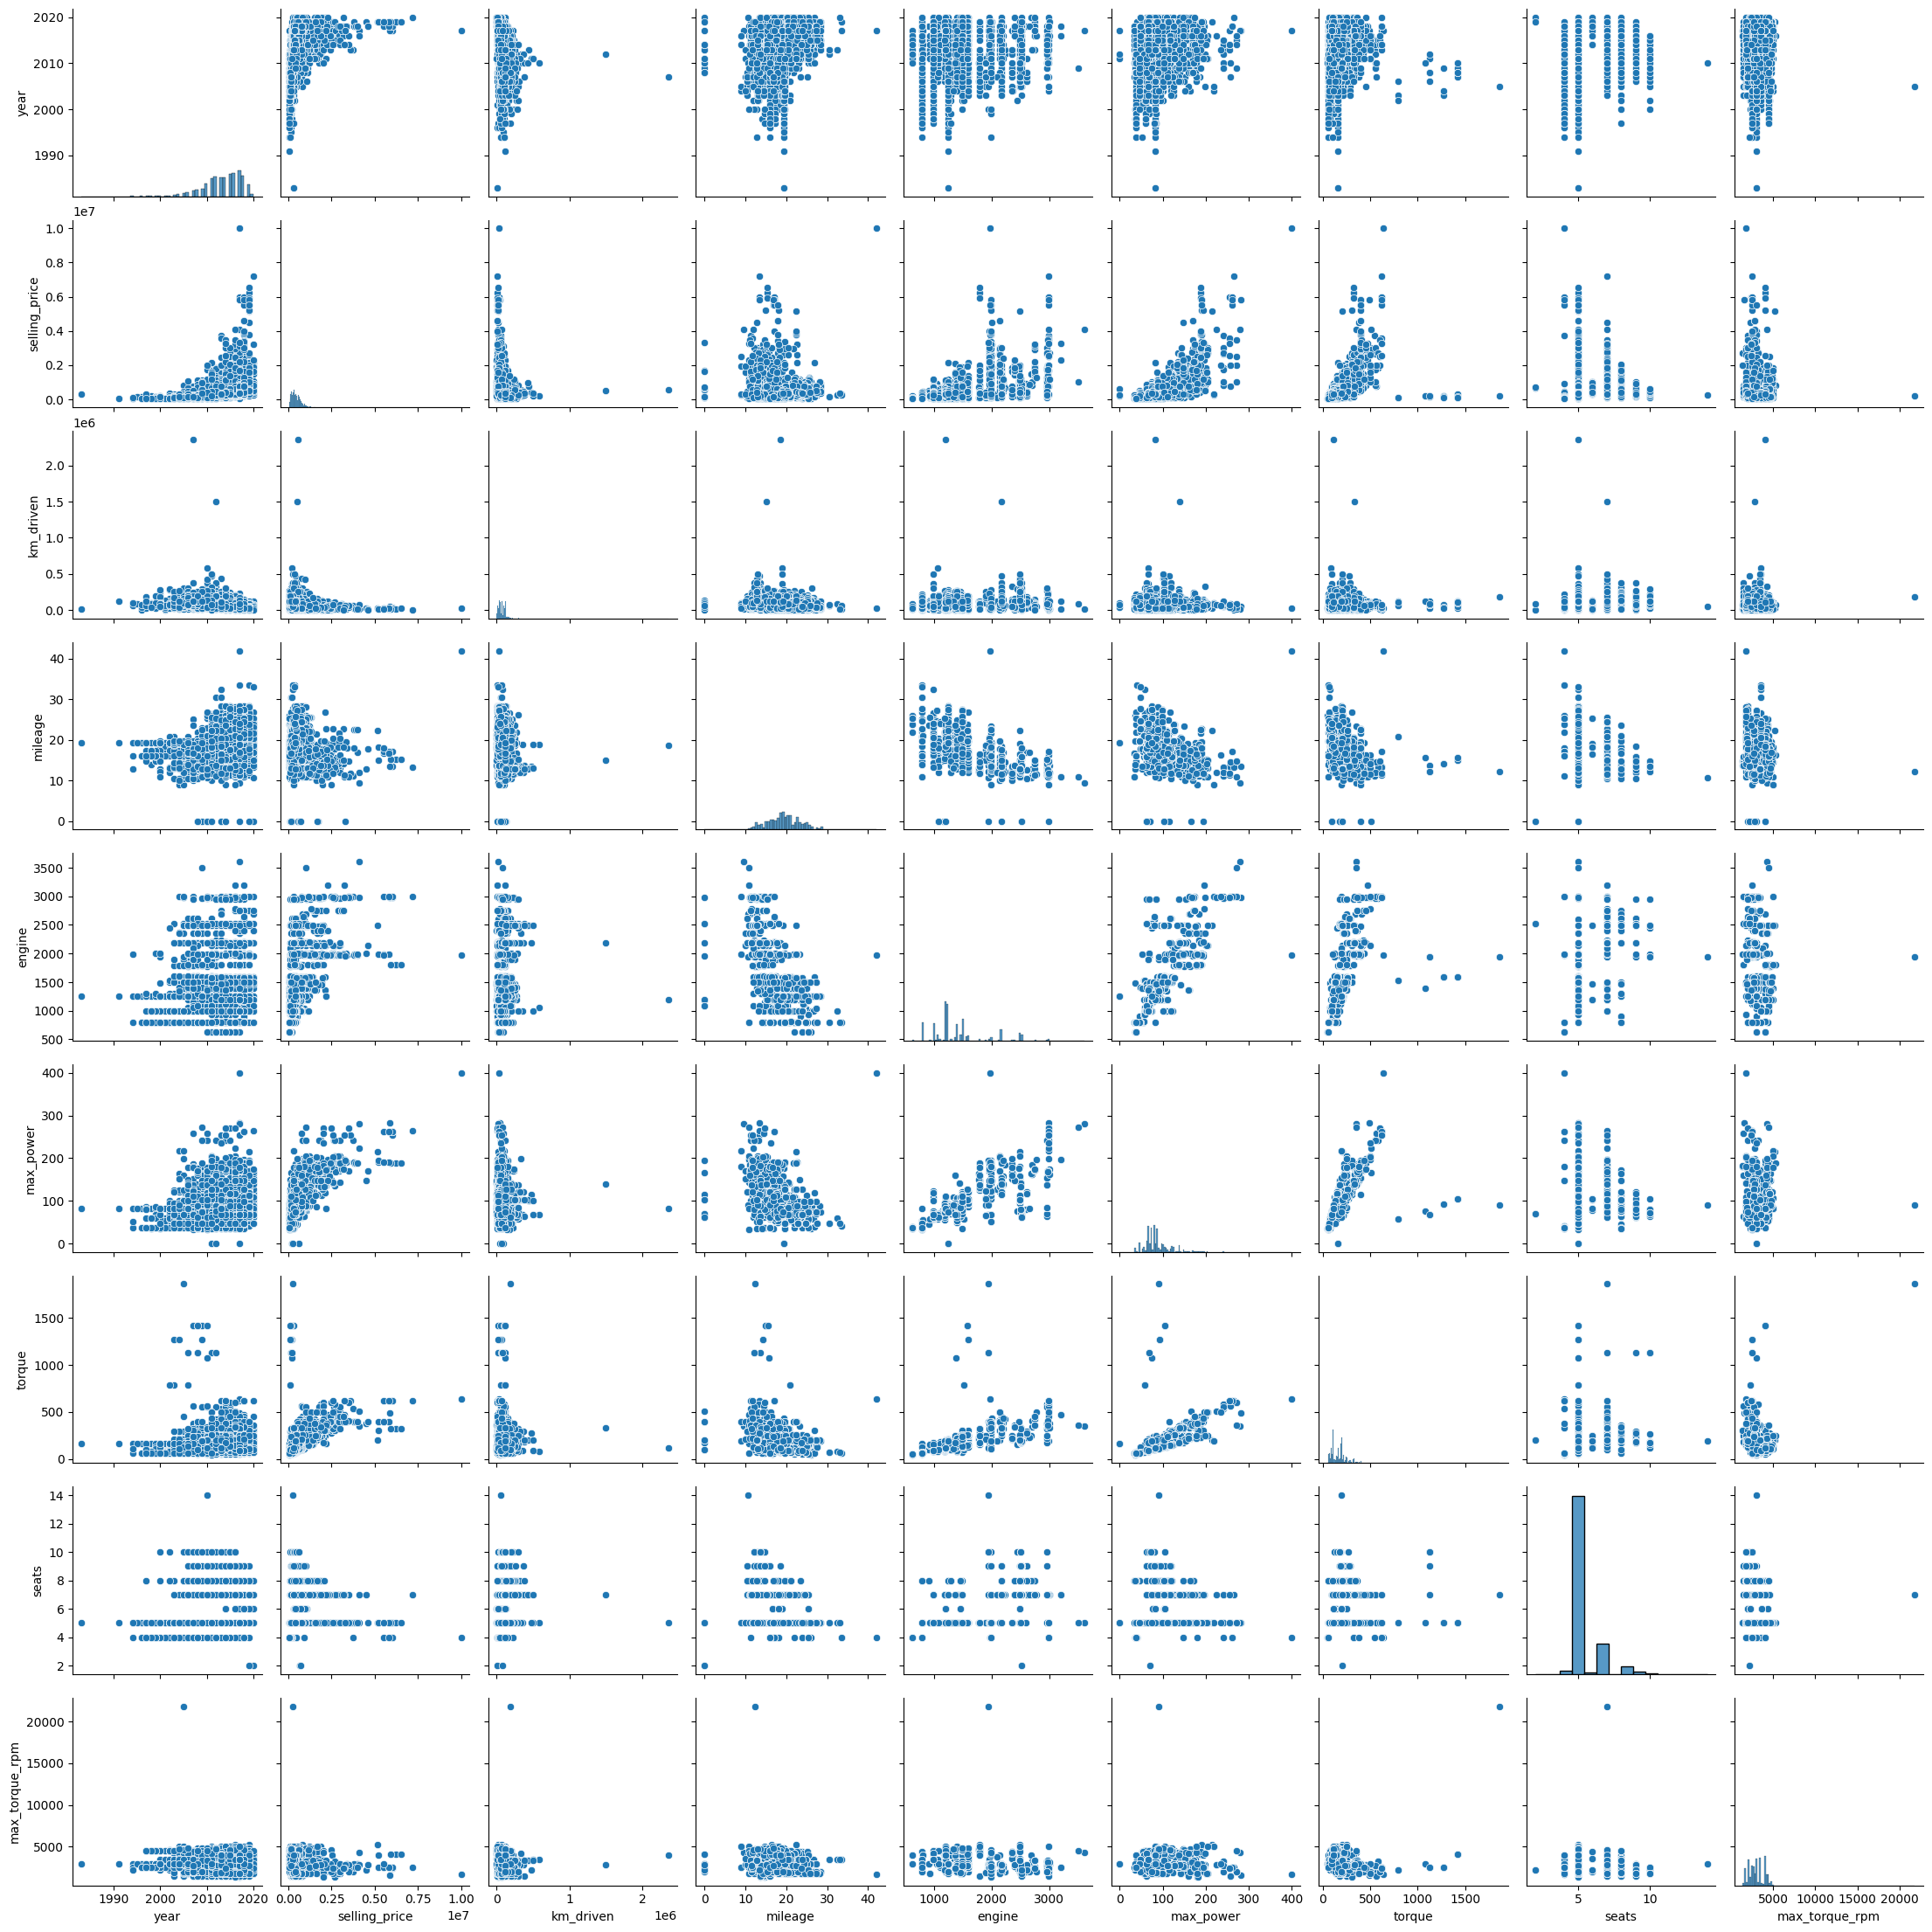

In [41]:
sns.pairplot(df_train)

Этот график не такой информативный, как можно было бы построить, беря признаки по отдельности. Но он позволяет сделать некоторые (возможно, далеко идущие) выводы. Впрочем, со многими из них (если не со всеми) вы бы справились умозрительно. Однако всегда приятно делать выводы, основываясь на данных.



* <font color='#FF6600'> Что можно сказать о связи предикторов с целевой переменной?
* А о корреляциях признаков? </font>

- Что касается связи с целевой переменной:
    - `Year`: ожидаемо, чем выше год, тем дороже стоимость машины
    - `km_driven`: чем меньше пробег машины, тем больше ее цена
    - `mileage`: особой связи нет за исключением того, что у средней стоимости машины средняя продолжительность пути ли литре топлива
    - `engine`: чем выше показатель признака, тем дороже машина
    - `max_power`: та же история, что и с `engine`
    - `torque`: заметно несколько "выбросов", а так история повторяется с `engine` и `max_power`
    - `seats`: особой связи нет
    - `max_torque_rpm`: также, что и у `seats`
- О корреляции признаков: в целом, здесь достаточно логичная картина, например, `max_power` неплохо так коррелирует с `torque` и `engine`, но вообще прямой зависимости не наблюдается

(0.25 балла) <font color='#9933CC'>Постройте pairplot по тестовым данным</font> и ответьте на вопрос <font color='#FF6600'>"Похожими ли оказались совокупности при разделении на трейн и тест?"</font>

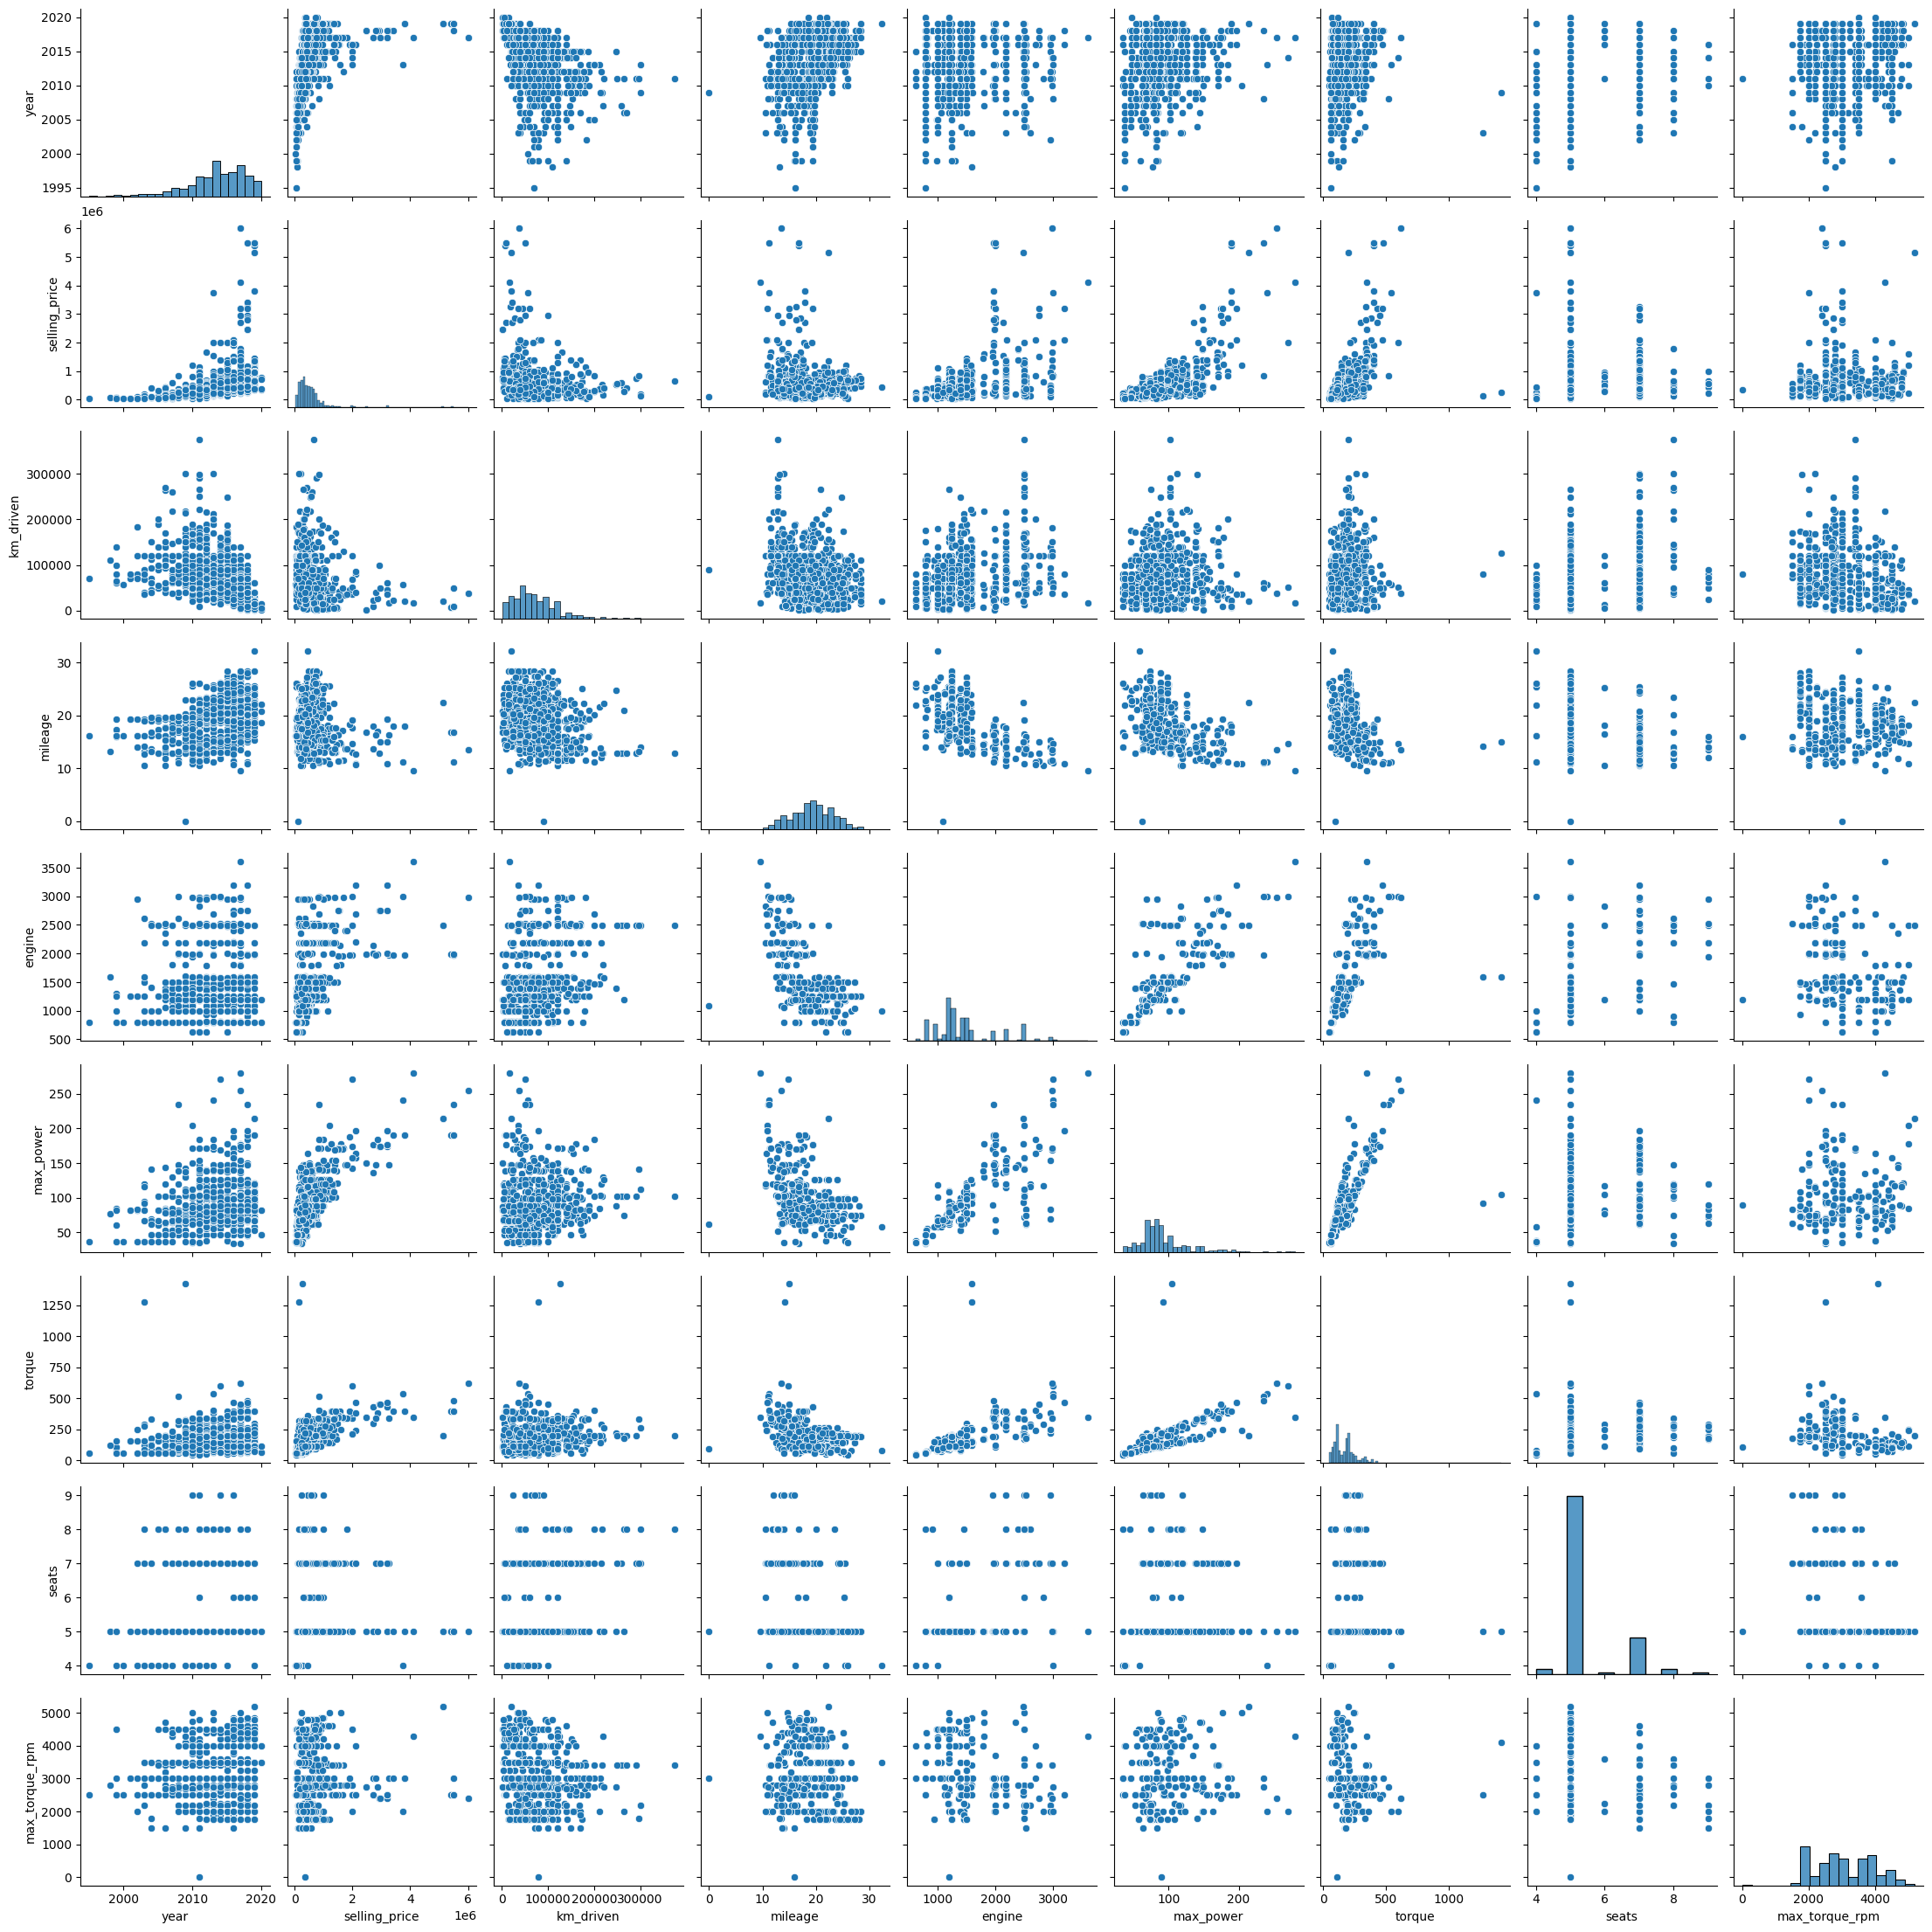

In [42]:
sns.pairplot(df_test)

Получилось очень даже похоже, не сказал бы, что распределения разительным образом поменялись

(0.25 балла) <font color='#9933CC'>Для трейна давайте построим тепловую карту (heatmap из библиотеки seaborn) попарных корреляций числовых колонок</font>

<AxesSubplot: >

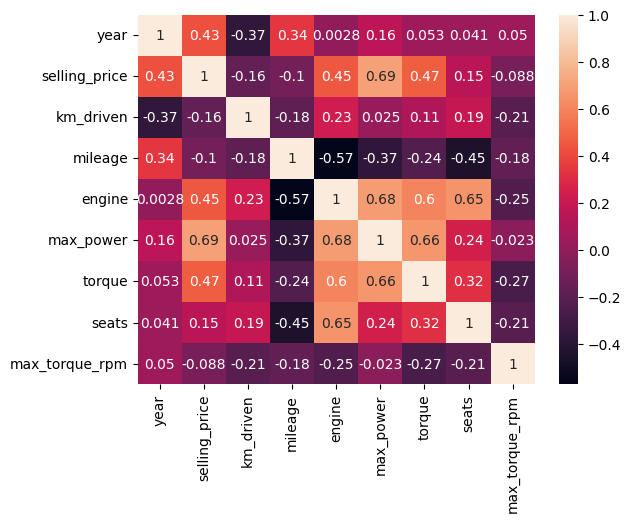

In [43]:
sns.heatmap(
    df_train[
        [
            "year",
            "selling_price",
            "km_driven",
            "mileage",
            "engine",
            "max_power",
            "torque",
            "seats",
            "max_torque_rpm",
        ]
    ].corr(),
    annot=True,
)

Ответьте, пожалуйста, на вопросы: 
* <font color='#FF6600'>Какие 2 признака наименее скоррелированы между собой?</font>
* <font color='#FF6600'>Между какими наблюдается довольно сильная положительная линейная зависимость?</font>
* <font color='#FF6600'>Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи.</font>

- Это `max_power` и `km_driven`: в целом, понятно, что макс. мощность двигателя не влияет на пробег, также хотелось бы упомянуть `seats` и `year`, хороший пример отсутствия зависимости
- Сильная (в данном случае сильная означает >=0.6 коэффициента) положительная зависимость наблюдается между следующими признаками: это `max_power` и `selling_price`, `max_power` и `engine`, `max_power` и `torque`, `torque` и `engine`, `seats` и `engine`
- Да, всё так, наличие отрицательного коэффициента корреляции говорит о том, что признаки зависимы, но зависимы обратно (при увеличении одного уменьшается второй)

(0.25 балла) <font color='#9933CC'> Отобразите диаграмму рассеяния для наиболее скореллированной пары **признаков** (на трейне) </font>

Если брать во внимание целевой признак:

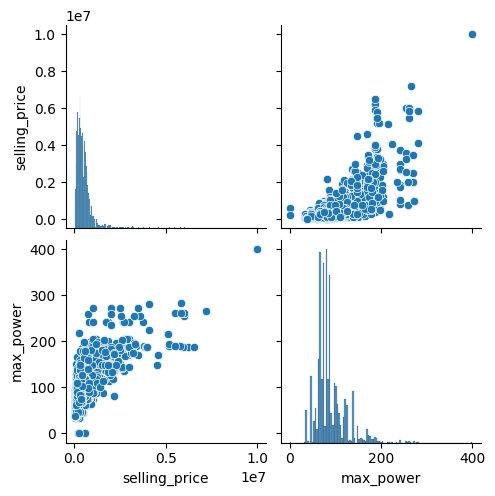

In [44]:
sns.pairplot(df_train[["selling_price", "max_power"]])

Иначе:

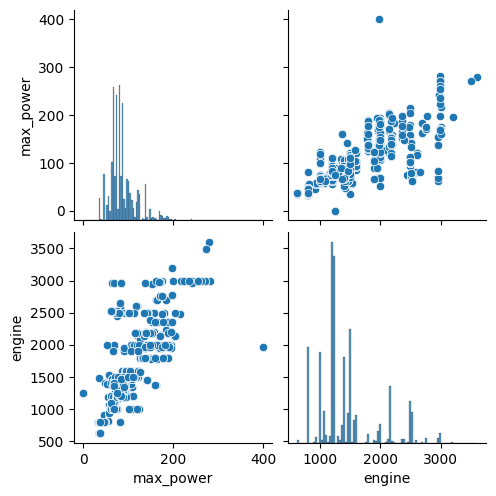

In [45]:
sns.pairplot(df_train[["max_power", "engine"]])

### Дополнительные визуализации (бонус 0.5 балла)

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

Думаю, стоит посмотреть на выбросы в данных. Всё-таки порой это играет важную роль, особенно при нормировке.

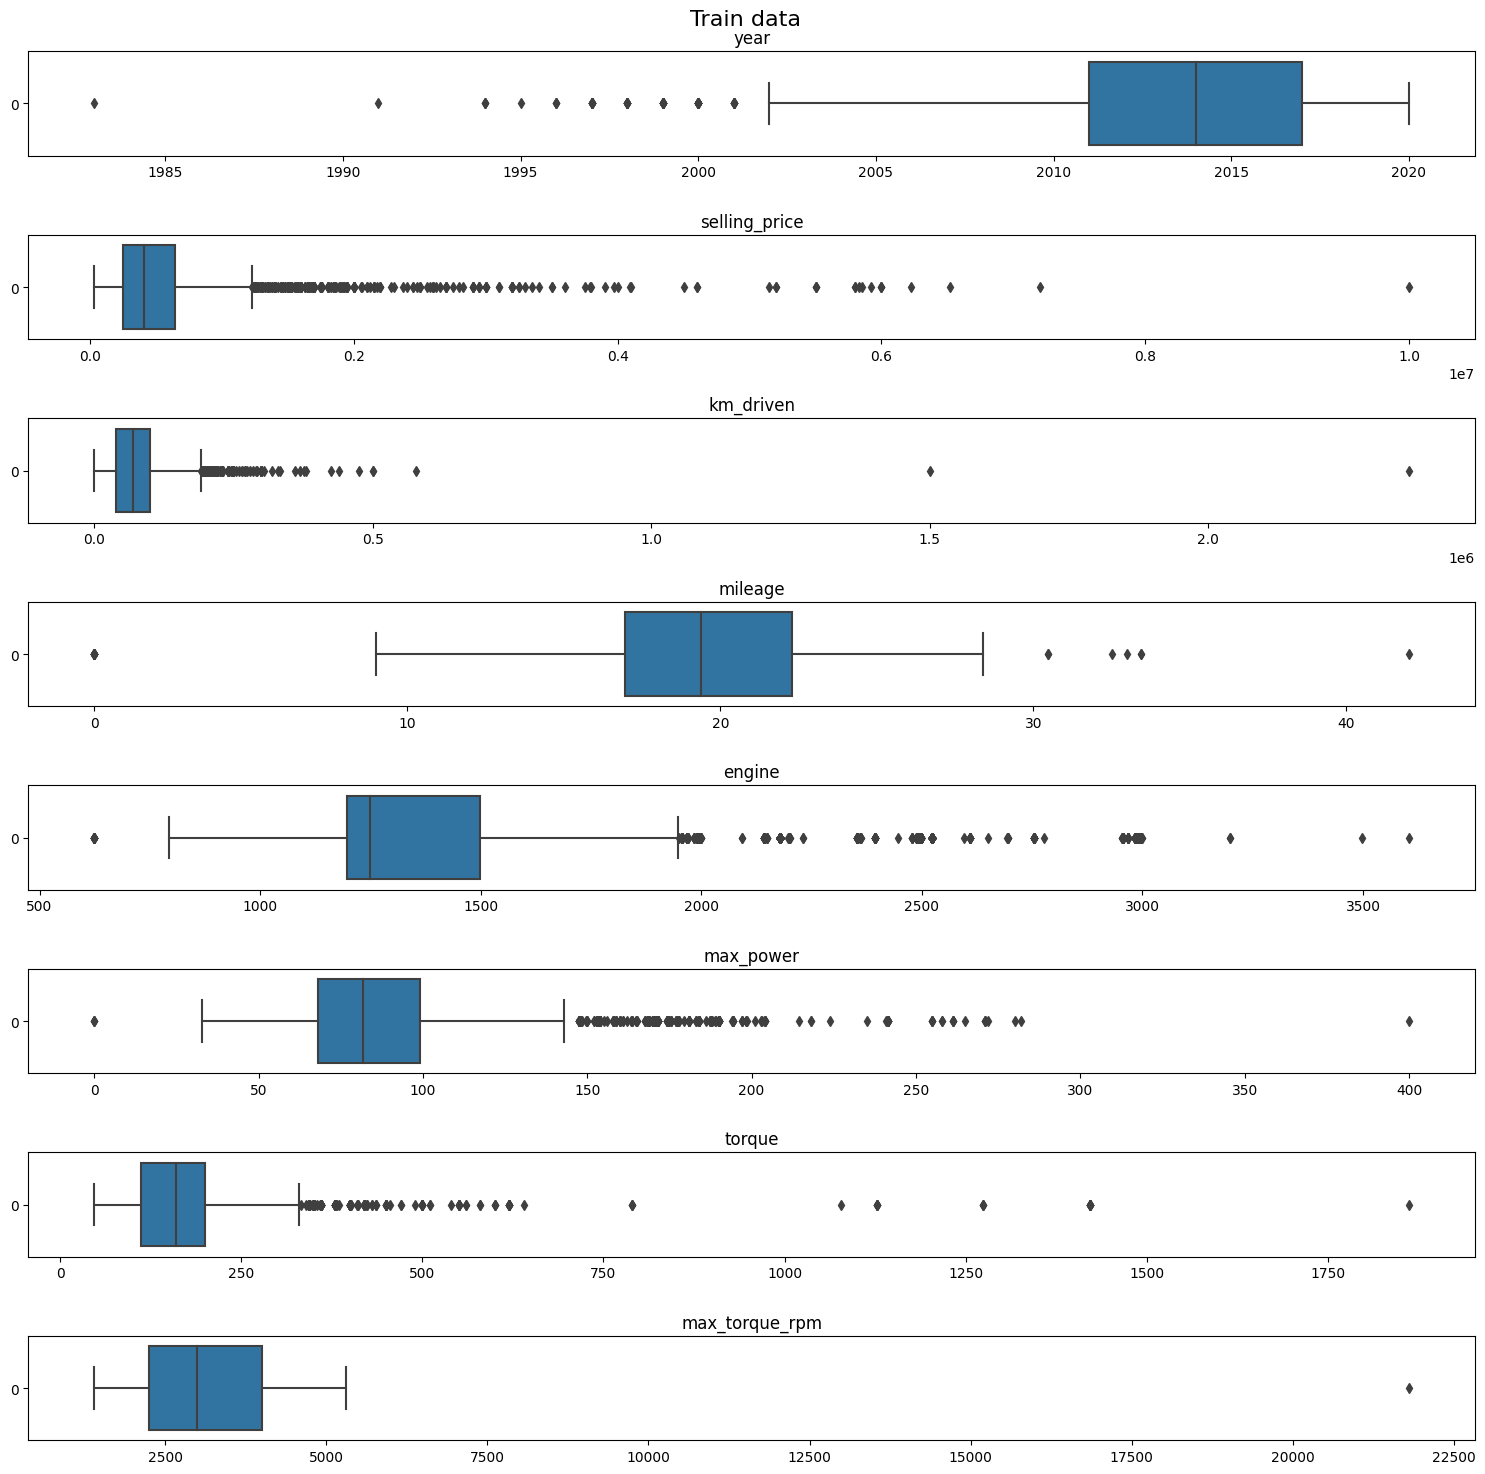

In [46]:
numeric_columns = df_train.select_dtypes(include=np.number).columns.tolist()
numeric_columns.remove("seats")

fig, axes = plt.subplots(ncols=1, nrows=len(numeric_columns), figsize=(15, 15))
for idx, col in enumerate(numeric_columns):
    sns.boxplot(df_train[col], orient="h", ax=axes[idx])
    axes[idx].set_title(col)

plt.suptitle("Train data", fontsize=16)
plt.tight_layout()

Про смысл boxplot'а рассказывать не буду, хотелось бы указать на факт того, что в числовых признаках в обучающем датасете практически везде присутствуют выбросы.

Что, в целом, нормально, главное, что предупреждены, значит вооружены.

Особенно много выбросов в признаках `selling_price` (немудрено, все-таки большинство автомобилей имеют цену около медианы, но есть и те, цены на которые гораздо выше среднего в связи с уникальностью / мощностью и т.п.), `km_driven` (тоже понятно, что будут попадаться экземпляры с большим пробегом), `max_power` (схожесть с целевой переменной, так как в основном машины производят с мощностью двигателя в около 100 л.с., а выше - это уже спорткары и т.п. штуки).

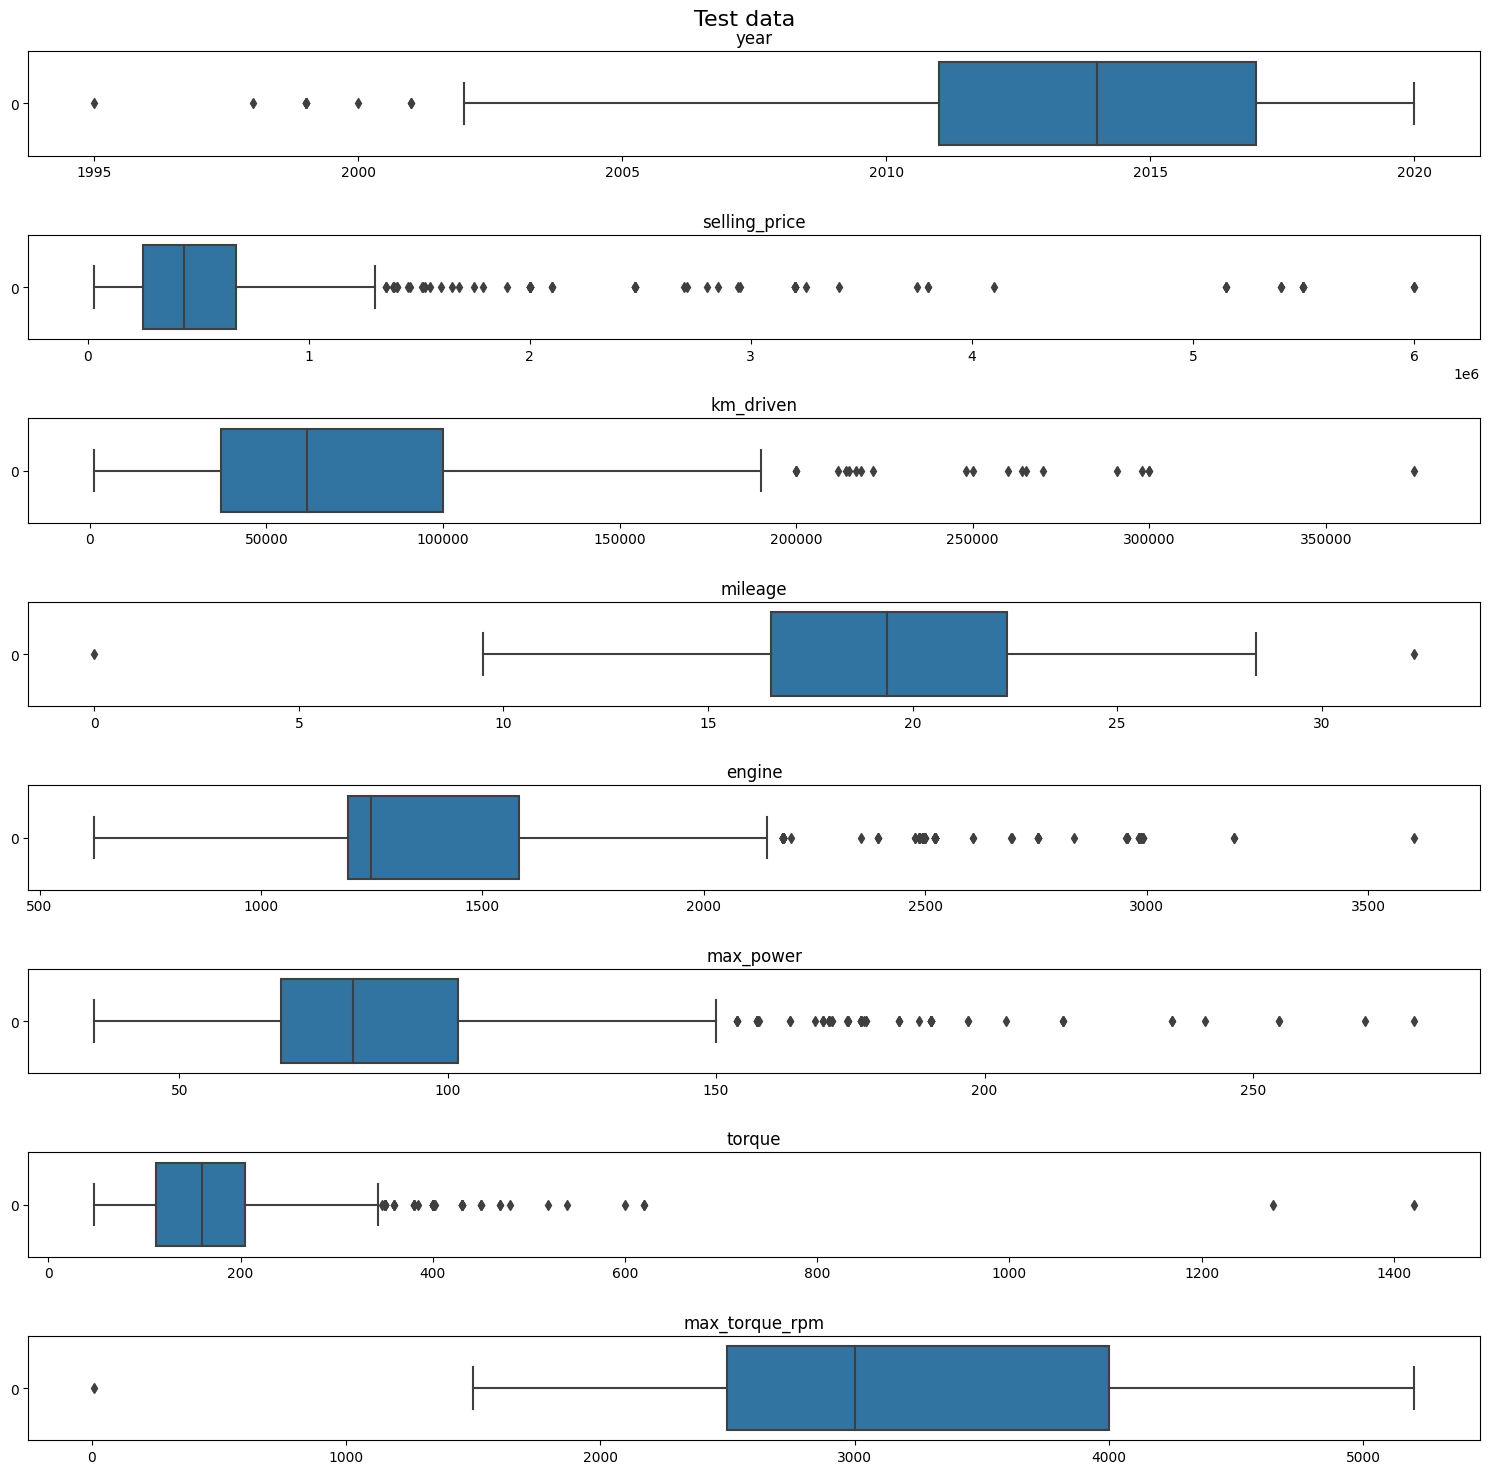

In [47]:
numeric_columns = df_test.select_dtypes(include=np.number).columns.tolist()
numeric_columns.remove("seats")

fig, axes = plt.subplots(ncols=1, nrows=len(numeric_columns), figsize=(15, 15))
for idx, col in enumerate(numeric_columns):
    sns.boxplot(df_test[col], orient="h", ax=axes[idx])
    axes[idx].set_title(col)

plt.suptitle("Test data", fontsize=16)
plt.tight_layout()

Ситуация с тестовыми данными не отличается от ситуации с обучающими, только выбросов уже меньше по причине размерности тестовой выборки.
Даже сохраняется относительное кол-во выбросов в сравнении между признаками.

# Часть 2 (1.25 балла) | Модель только на вещественных признаках

(0.05 балла) <font color='#9933CC'>В переменные ``y_train`` и ``y_test`` запишите значения целевых переменных. Столбцы ``selling_price`` из датафреймов необходимо удалить. Категориальные (все, кроме ``seats``) столбцы тоже.</font>

In [48]:
y_train = df_train["selling_price"]
X_train = df_train.drop(
    columns=["name", "fuel", "seller_type", "transmission", "owner", "selling_price"]
)

In [49]:
assert X_train.shape == (5840, 8)

In [50]:
y_test = df_test["selling_price"]
X_test = df_test.drop(
    columns=["name", "fuel", "seller_type", "transmission", "owner", "selling_price"]
)

In [51]:
assert X_test.shape == (1000, 8)

(0.2 балла) <font color='#9933CC'>Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и MSE для трейна и для теста</font>

**Замечание:** $R^2$ и MSE для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

In [53]:
lin_reg_default = LinearRegression()
lin_reg_default.fit(X_train, y_train)

LinearRegression()

In [54]:
print(
    f"R\N{SUPERSCRIPT TWO} оценка на обучении составила: "
    f"{round(r2_score(y_train, lin_reg_default.predict(X_train)), 4)}"
)

R² оценка на обучении составила: 0.6008


In [55]:
print(
    f"R\N{SUPERSCRIPT TWO} оценка на тесте составила: "
    f"{round(r2_score(y_test, lin_reg_default.predict(X_test)), 4)}"
)

R² оценка на тесте составила: 0.6001


In [56]:
print(
    f"MSE оценка на обучении составила: "
    f"{round(MSE(y_train, lin_reg_default.predict(X_train)), 4)}"
)

MSE оценка на обучении составила: 114415863454.4158


In [57]:
print(
    f"MSE оценка на тесте составила: "
    f"{round(MSE(y_test, lin_reg_default.predict(X_test)), 4)}"
)

MSE оценка на тесте составила: 229868783526.6982


In [58]:
lin_reg_default.predict(X_train)

array([407607.2882053 , 723844.83770268, 389588.1666749 , ...,
       362526.31579427, 500267.50174643, 233291.04624335])

Хорошо получилось с тем, что модель начала предсказывать отрицательную цену :).
Я так понимаю, всему виной то, что использовали точную аналитическую формулу и имели скоррелированные признаки, что в итоге и дало такой результат.

Запомните правило:

> Использую линейную модель -- стандартизирую фичи

(0.25 балла) <font color='#9933CC'>Воспользуемся им</font>


In [59]:
from sklearn.preprocessing import StandardScaler

In [60]:
standard_scaler = StandardScaler()
X_train_standardized = standard_scaler.fit_transform(X_train)
X_test_standardized = standard_scaler.transform(X_test)

In [61]:
lin_reg_standardized = LinearRegression()
lin_reg_standardized.fit(X_train_standardized, y_train)

LinearRegression()

In [62]:
r_train_standardized = r2_score(
    y_train, lin_reg_standardized.predict(X_train_standardized)
)
r_test_standardized = r2_score(
    y_test, lin_reg_standardized.predict(X_test_standardized)
)
print(
    f"R\N{SUPERSCRIPT TWO} оценка на обучении составила: "
    f"{round(r_train_standardized, 4)}"
)
print(
    f"R\N{SUPERSCRIPT TWO} оценка на тесте составила: "
    f"{round(r_test_standardized, 4)}"
)

R² оценка на обучении составила: 0.6008
R² оценка на тесте составила: 0.6001


In [63]:
mse_train_standardized = MSE(
    y_train, lin_reg_standardized.predict(X_train_standardized)
)
mse_test_standardized = MSE(y_test, lin_reg_standardized.predict(X_test_standardized))
print(f"MSE оценка на обучении составила: " f"{round(mse_train_standardized, 4)}")
print(f"MSE оценка на тесте составила: " f"{round(mse_test_standardized, 4)}")

MSE оценка на обучении составила: 114415863454.4158
MSE оценка на тесте составила: 229868783526.6992


Не очень результативно.

Зато уже сейчас можем интерпретировать модель. <font color='#FF6600'>"Какой признак оказался наиболее информативным в предсказании цены?"</font>

In [64]:
np.concatenate(
    [
        lin_reg_standardized.coef_[..., np.newaxis],
        X_train.columns.values[..., np.newaxis],
    ],
    axis=1,
)

array([[165497.84507346674, 'year'],
       [-48915.29309496822, 'km_driven'],
       [-7791.042751818837, 'mileage'],
       [23065.059266534045, 'engine'],
       [328185.3476901698, 'max_power'],
       [8257.05174816539, 'torque'],
       [-30277.425111747805, 'seats'],
       [-57692.472110646115, 'max_torque_rpm']], dtype=object)

Получилось так, что самым значимым признаком у нас оказался `max_power`. Вторым по значимости, как ни странно, `year`.

(0.25 балла) <font color='#9933CC'>Теперь попробуем Lasso-регрессию.</font> Здесь и дальше обучайте модели на нормализованных признаках

In [65]:
from sklearn.linear_model import Lasso

In [66]:
lasso_regression = Lasso()
lasso_regression.fit(X_train_standardized, y_train)

Lasso()

In [67]:
r_train_lasso = r2_score(y_train, lasso_regression.predict(X_train_standardized))
r_test_lasso = r2_score(y_test, lasso_regression.predict(X_test_standardized))
print(
    f"R\N{SUPERSCRIPT TWO} оценка на обучении составила: " f"{round(r_train_lasso, 4)}"
)
print(f"R\N{SUPERSCRIPT TWO} оценка на тесте составила: " f"{round(r_test_lasso, 4)}")

R² оценка на обучении составила: 0.6008
R² оценка на тесте составила: 0.6001


In [68]:
mse_train_lasso = MSE(y_train, lasso_regression.predict(X_train_standardized))
mse_test_lasso = MSE(y_test, lasso_regression.predict(X_test_standardized))
print(f"MSE оценка на обучении составила: " f"{round(mse_train_lasso, 4)}")
print(f"MSE оценка на тесте составила: " f"{round(mse_test_lasso, 4)}")

MSE оценка на обучении составила: 114415863467.987
MSE оценка на тесте составила: 229869515821.2657


<font color='#FF6600'>Занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Почему же?</font>

In [69]:
np.concatenate(
    [lasso_regression.coef_[..., np.newaxis], X_train.columns.values[..., np.newaxis]],
    axis=1,
)

array([[165495.64810179177, 'year'],
       [-48914.34820306822, 'km_driven'],
       [-7787.764714479827, 'mileage'],
       [23063.04818318275, 'engine'],
       [328186.7604060213, 'max_power'],
       [8256.4076008332, 'torque'],
       [-30273.445221900867, 'seats'],
       [-57690.397209381605, 'max_torque_rpm']], dtype=object)

Веса вообще не изменились по сравнению с обычной линейной регрессией.
Думаю, что всё дело в выбросах в выборке, что приводит к тому, что в процессе решения точной аналитической формулой _Lasso_ попросту не справляется.

(0.25 балла) <font color='#9933CC'>Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии</font>

Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [70]:
from sklearn.model_selection import GridSearchCV

In [71]:
param_grid = {"alpha": [0.001, 0.01, 0.1, 0.5, 1, 10, 100], "positive": [True, False]}
lasso_grid = GridSearchCV(Lasso(), param_grid, cv=10)

In [72]:
lasso_grid.fit(X_train_standardized, y_train)

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10, 100],
                         'positive': [True, False]})

In [73]:
lasso_grid_best = lasso_grid.best_estimator_

In [74]:
print(lasso_grid.best_params_)

{'alpha': 100, 'positive': False}


<font color='#FF6600'>Сколько грид-сёрчу пришлось обучать моделей?</font>

In [75]:
len(lasso_grid.cv_results_["mean_fit_time"]) * 10

140

Если включать кол-во моделей, которые были обучены в ходе работы кросс-валидации, то 140. Если говорить только о различных параметрах, то тогда 14.

<font color='#FF6600'>Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?</font>

In [76]:
lasso_grid_best.alpha

100

In [77]:
print(
    np.concatenate(
        [
            lasso_grid_best.coef_[..., np.newaxis],
            X_train.columns.values[..., np.newaxis],
        ],
        axis=1,
    )
)

[[165270.44335701058 'year']
 [-48821.93624918277 'km_driven']
 [-7452.042679161588 'mileage']
 [22867.23241111728 'engine']
 [328329.14892581303 'max_power']
 [8192.116614252036 'torque']
 [-29875.169477804946 'seats']
 [-57481.21934239149 'max_torque_rpm']]


Не особо что-то поменялось, хотя уже использовался коэффициент $\alpha = 100.$ Влияние выбросов ого-го какое!

(0.25 балла) <font color='#9933CC'>Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)-регрессии</font>

In [78]:
from sklearn.linear_model import ElasticNet

In [79]:
param_grid = {
    "alpha": [0.001, 0.01, 0.1, 0.5, 1, 10, 100],
    "l1_ratio": [0.001, 0.01, 0.1, 0.5, 1],
}
elastic_net_grid = GridSearchCV(ElasticNet(), param_grid, cv=10)

In [80]:
elastic_net_grid.fit(X_train_standardized, y_train)

GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10, 100],
                         'l1_ratio': [0.001, 0.01, 0.1, 0.5, 1]})

<font color='#FF6600'>Какие гиперпараметры соответствуют лучшей из перебранных моделей?</font>

In [81]:
elastic_net_grid.best_params_

{'alpha': 0.1, 'l1_ratio': 0.001}

In [82]:
elastic_net_grid.best_estimator_.coef_

array([153882.19993017, -51004.69967231,   -728.12263455,  52670.87206841,
       269702.89357458,  33712.43423234, -32402.03836846, -39921.15465459])

Веса стали меньше, но не сильно, печалька :(.

In [83]:
r_train_elastic_net = r2_score(
    y_train, elastic_net_grid.best_estimator_.predict(X_train_standardized)
)
r_test_elastic_net = r2_score(
    y_test, elastic_net_grid.best_estimator_.predict(X_test_standardized)
)
print(
    f"R\N{SUPERSCRIPT TWO} оценка на обучении составила: "
    f"{round(r_train_elastic_net, 4)}"
)
print(
    f"R\N{SUPERSCRIPT TWO} оценка на тесте составила: "
    f"{round(r_test_elastic_net, 4)}"
)

R² оценка на обучении составила: 0.5954
R² оценка на тесте составила: 0.5773


In [84]:
mse_train_elastic_net = MSE(
    y_train, elastic_net_grid.best_estimator_.predict(X_train_standardized)
)
mse_test_elastic_net = MSE(
    y_test, elastic_net_grid.best_estimator_.predict(X_test_standardized)
)
print(f"MSE оценка на обучении составила: " f"{round(mse_train_elastic_net, 4)}")
print(f"MSE оценка на тесте составила: " f"{round(mse_test_elastic_net, 4)}")

MSE оценка на обучении составила: 115982493666.4861
MSE оценка на тесте составила: 242984009065.6362


Предлагаем вам оставить попытки заметно улучшить качество модели регуляризацией и перейти к следующей части задания.

# Часть 3 (0.75 балла) | Добавляем категориальные фичи



(0 баллов) <font color='#9933CC'>Из ``df_train`` удалите столбцы с целевой переменной и названием автомобиля.</font>

In [85]:
X_train_cat = df_train.drop(columns=["selling_price", "name"])
X_test_cat = df_test.drop(columns=["selling_price", "name"])

In [86]:
assert X_train_cat.shape == (5840, 12)

In [87]:
X_train_cat.describe(include="object")

,fuel,seller_type,transmission,owner
count,5840,5840,5840,5840
unique,4,3,2,5
top,Diesel,Individual,Manual,First Owner
freq,3177,5223,5336,3603


(0.5 балла) <font color='#9933CC'>Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования</font>

> Обратите внимание, что во избежание мультиколлинеарности следует избавиться от одного из полученных столбцов при кодировании каждого признака методом OneHot. 

In [88]:
from sklearn.preprocessing import (
    OneHotEncoder,  # или можно использовать get_dummies из библиотеки pandas
)

In [89]:
encoder = OneHotEncoder(drop="first", sparse=False)
X_train_cat_part = encoder.fit_transform(
    X_train_cat[["fuel", "seller_type", "transmission", "owner", "seats"]]
)
X_test_cat_part = encoder.transform(
    X_test_cat[["fuel", "seller_type", "transmission", "owner", "seats"]]
)

X_train_cat = X_train_cat.drop(
    columns=["fuel", "seller_type", "transmission", "owner", "seats"]
)
X_test_cat = X_test_cat.drop(
    columns=["fuel", "seller_type", "transmission", "owner", "seats"]
)

X_train_cat = np.concatenate([X_train_cat.to_numpy(), X_train_cat_part], axis=1)
X_test_cat = np.concatenate([X_test_cat.to_numpy(), X_test_cat_part], axis=1)

In [90]:
encoder.categories_

[array(['CNG', 'Diesel', 'LPG', 'Petrol'], dtype=object),
 array(['Dealer', 'Individual', 'Trustmark Dealer'], dtype=object),
 array(['Automatic', 'Manual'], dtype=object),
 array(['First Owner', 'Fourth & Above Owner', 'Second Owner',
        'Test Drive Car', 'Third Owner'], dtype=object),
 array([ 2,  4,  5,  6,  7,  8,  9, 10, 14])]

In [91]:
print(X_train_cat.shape, X_test_cat.shape)

(5840, 25) (1000, 25)


(0.25 балла) <font color='#9933CC'>Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV`.</font> В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.

<font color='#FF6600'>Удалось ли улучшить качество предсказаний?</font>

In [92]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [93]:
param_grid = {"alpha": [0.001, 0.01, 0.1, 0.5, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), param_grid, cv=10, scoring="r2")

In [94]:
ridge_grid.fit(X_train_cat, y_train)

/home/proven_warrior/hse/intro_to_ml/homework_1/mlvenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.04152e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10, 100]},
             scoring='r2')

In [95]:
ridge_grid.best_params_

{'alpha': 10}

In [96]:
ridge_grid.best_score_

0.627513289896764

In [97]:
np.set_printoptions(suppress=True)

In [98]:
ridge_grid.best_estimator_.coef_

array([  37914.34743424,      -0.4751374 ,    6594.05344628,
            81.44703876,    9218.80710921,     153.74812707,
           -74.65408779,  -67220.06417037,  136963.84900213,
         -1236.64862436, -111652.48248877,  -87742.77584155,
       -281147.00128812,  -41194.46850495,  -56209.34419922,
        930001.68867991,  -42181.52341924,  416670.17200049,
        -70117.38128841, -149501.13332143,  -75705.21279475,
        -16018.33239706,  -61501.39023362,  -37269.25089555,
        -17590.19875217])

In [99]:
r_train_ridge = r2_score(y_train, ridge_grid.best_estimator_.predict(X_train_cat))
r_test_ridge = r2_score(y_test, ridge_grid.best_estimator_.predict(X_test_cat))
print(
    f"R\N{SUPERSCRIPT TWO} оценка на обучении составила: " f"{round(r_train_ridge, 4)}"
)
print(f"R\N{SUPERSCRIPT TWO} оценка на тесте составила: " f"{round(r_test_ridge, 4)}")

R² оценка на обучении составила: 0.66
R² оценка на тесте составила: 0.6522


In [100]:
mse_train_ridge = MSE(y_train, ridge_grid.best_estimator_.predict(X_train_cat))
mse_test_ridge = MSE(y_test, ridge_grid.best_estimator_.predict(X_test_cat))
print(f"MSE оценка на обучении составила: {round(mse_train_ridge, 4)}")
print(f"MSE оценка на тесте составила: {round(mse_test_ridge, 4)}")

MSE оценка на обучении составила: 97451801358.0336
MSE оценка на тесте составила: 199921740761.1849


Ура, наконец-то удалось добиться улучшения результата! 

Однако коэффициенты все такие же громоздкие - даже стали больше (930 тысяч вес - это сильно).

# Часть 4 - бонусная (2 балла) | Feature Engineering 

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

## Выбросы

Хотелось бы поработать с выбросами - все-таки, быть может, вся проблема в них.

Для начала найдем эти самые выбросы в обучающей и тестовой выборках.

Разберем дополнительно три случая:
- удалить выбросы в принципе;
- воспользоваться _Robust Scaler_ из _Sklearn_;
- заменить выбросы на какое-нибудь среднее значение (моду или что-то подобное)

In [101]:
def get_dfs_with_edited_outliers(
    df_for_edit: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_wo_outliers = deepcopy(df_for_edit)
    df_outliers_median = deepcopy(df_for_edit)
    for col in numeric_columns:
        q_25, q_75 = (
            df_wo_outliers[col].quantile(0.25),
            df_wo_outliers[col].quantile(0.75),
        )
        iqr = q_75 - q_25
        outliers_factor = iqr * 1.5

        lower_outliers_for_col = df_wo_outliers[
            df_wo_outliers[col] < q_25 - outliers_factor
        ].index

        df_outliers_median.loc[lower_outliers_for_col, col] = df_outliers_median[
            col
        ].median()
        df_wo_outliers = df_wo_outliers.drop(lower_outliers_for_col)

        upper_outliers_for_col = df_wo_outliers[
            df_wo_outliers[col] > q_75 + outliers_factor
        ].index

        df_outliers_median.loc[upper_outliers_for_col, col] = df_outliers_median[
            col
        ].median()
        df_wo_outliers = df_wo_outliers.drop(upper_outliers_for_col)

    return df_wo_outliers, df_outliers_median

In [102]:
df_train_wo_outliers, df_train_outliers_median = get_dfs_with_edited_outliers(df_train)
_, df_test_outliers_median = get_dfs_with_edited_outliers(df_test)
df_test_wo_outliers = deepcopy(df_test)

In [103]:
df_train_wo_outliers.shape, df_train_outliers_median.shape, df_train.shape

((4417, 14), (5840, 14), (5840, 14))

In [104]:
df_test_wo_outliers.shape, df_test_outliers_median.shape, df_test.shape

((1000, 14), (1000, 14), (1000, 14))

Теперь стандартизируем числовые признаки (отдельно будет идти метод с _Robust Scaler_), обработаем категориальные, как и до этого.

##### Без _Robust Scaler_

In [105]:
X_train_num_wo_outliers = df_train_wo_outliers[numeric_columns].drop(
    columns="selling_price"
)
y_train_wo_outliers = df_train_wo_outliers["selling_price"]

X_train_num_outliers_median = df_train_outliers_median[numeric_columns].drop(
    columns="selling_price"
)
y_train_outliers_median = df_train_outliers_median["selling_price"]

X_test_num_wo_outliers = df_test_wo_outliers[numeric_columns].drop(
    columns="selling_price"
)
y_test_wo_outliers = df_test_wo_outliers["selling_price"]

X_test_num_outliers_median = df_test_outliers_median[numeric_columns].drop(
    columns="selling_price"
)
y_test_outliers_median = df_test_outliers_median["selling_price"]

In [106]:
scaler_wo_outliers = StandardScaler()
X_train_num_wo_outliers = scaler_wo_outliers.fit_transform(X_train_num_wo_outliers)
X_test_num_wo_outliers = scaler_wo_outliers.transform(X_test_num_wo_outliers)

scaler_outliers_median = StandardScaler()
X_train_num_outliers_median = scaler_outliers_median.fit_transform(
    X_train_num_outliers_median
)
X_test_num_outliers_median = scaler_outliers_median.transform(
    X_test_num_outliers_median
)

In [107]:
encoder_wo_outliers = OneHotEncoder(drop="first", sparse=False, handle_unknown="ignore")
X_train_cat_wo_outliers = encoder_wo_outliers.fit_transform(
    df_train_wo_outliers[["fuel", "seller_type", "transmission", "owner", "seats"]]
)
X_test_cat_wo_outliers = encoder_wo_outliers.transform(
    df_test_wo_outliers[["fuel", "seller_type", "transmission", "owner", "seats"]]
)

X_train_wo_outliers = np.concatenate(
    [X_train_num_wo_outliers, X_train_cat_wo_outliers], axis=1
)
X_test_wo_outliers = np.concatenate(
    [X_test_num_wo_outliers, X_test_cat_wo_outliers], axis=1
)

encoder_outliers_median = OneHotEncoder(drop="first", sparse=False)
X_train_cat_outliers_median = encoder_outliers_median.fit_transform(
    df_train_outliers_median[["fuel", "seller_type", "transmission", "owner", "seats"]]
)
X_test_cat_outliers_median = encoder_outliers_median.transform(
    df_test_outliers_median[["fuel", "seller_type", "transmission", "owner", "seats"]]
)

X_train_outliers_median = np.concatenate(
    [X_train_num_outliers_median, X_train_cat_outliers_median], axis=1
)
X_test_outliers_median = np.concatenate(
    [X_test_num_outliers_median, X_test_cat_outliers_median], axis=1
)

/home/proven_warrior/hse/intro_to_ml/homework_1/mlvenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [108]:
X_train_wo_outliers.shape, X_test_wo_outliers.shape

((4417, 20), (1000, 20))

In [109]:
X_train_outliers_median.shape, X_test_outliers_median.shape

((5840, 25), (1000, 25))

Попробуем _Ridge_-регрессию, раз до этого с ней повезло.

In [110]:
param_grid = {"alpha": [0.001, 0.01, 0.1, 0.5, 1, 10, 100]}
ridge_grid_wo_outliers = GridSearchCV(Ridge(), param_grid, cv=10, scoring="r2")

In [111]:
ridge_grid_wo_outliers.fit(X_train_wo_outliers, y_train_wo_outliers)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10, 100]},
             scoring='r2')

In [112]:
ridge_grid_wo_outliers.best_params_, ridge_grid_wo_outliers.best_score_

({'alpha': 0.5}, 0.7637129311370421)

In [113]:
r_train_wo_outliers = r2_score(
    y_train_wo_outliers,
    ridge_grid_wo_outliers.best_estimator_.predict(X_train_wo_outliers),
)
r_test_wo_outliers = r2_score(
    y_test_wo_outliers,
    ridge_grid_wo_outliers.best_estimator_.predict(X_test_wo_outliers),
)
test_rmse_wo_outliers = mean_squared_error(
    y_test_wo_outliers,
    ridge_grid_wo_outliers.best_estimator_.predict(X_test_wo_outliers),
    squared=False,
)
print(
    f"R\N{SUPERSCRIPT TWO} оценка на обучении составила: "
    f"{round(r_train_wo_outliers, 4)}"
)
print(
    f"R\N{SUPERSCRIPT TWO} оценка на тесте составила: "
    f"{round(r_test_wo_outliers, 4)}"
)
print(f"RMSE на тесте: {round(test_rmse_wo_outliers, 4)}")

R² оценка на обучении составила: 0.7686
R² оценка на тесте составила: 0.4404
RMSE на тесте: 567158.9825


Не особо нам помогло удаление выбросов, учитывая, что на тесте оценка даже хуже, чем без всяких танцев с бубном.

In [114]:
param_grid = {"alpha": [0.001, 0.01, 0.1, 0.5, 1, 10, 100]}
ridge_grid_outliers_median = GridSearchCV(Ridge(), param_grid, cv=10, scoring="r2")

In [115]:
ridge_grid_outliers_median.fit(X_train_outliers_median, y_train_outliers_median)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10, 100]},
             scoring='r2')

In [116]:
ridge_grid_outliers_median.best_params_, ridge_grid_outliers_median.best_score_

({'alpha': 0.1}, 0.528453847113436)

In [117]:
r_train_outliers_median = r2_score(
    y_train_outliers_median,
    ridge_grid_outliers_median.best_estimator_.predict(X_train_outliers_median),
)
r_test_outliers_median = r2_score(
    y_test_outliers_median,
    ridge_grid_outliers_median.best_estimator_.predict(X_test_outliers_median),
)
test_rmse_outliers_median = mean_squared_error(
    y_test_outliers_median,
    ridge_grid_outliers_median.best_estimator_.predict(X_test_outliers_median),
    squared=False,
)
print(
    f"R\N{SUPERSCRIPT TWO} оценка на обучении составила: "
    f"{round(r_train_outliers_median, 4)}"
)
print(
    f"R\N{SUPERSCRIPT TWO} оценка на тесте составила: "
    f"{round(r_test_outliers_median, 4)}"
)

print(f"RMSE на тесте: {round(test_rmse_outliers_median, 4)}")

R² оценка на обучении составила: 0.5407
R² оценка на тесте составила: 0.5176
RMSE на тесте: 172904.3545


Здесь тоже не ахти результат.

##### С _Robust Scaler_

In [118]:
def process_outliers_with_robust_scaler(
    df_train: pd.DataFrame, df_test: pd.DataFrame, scale_target: bool = False
):
    X_train_num_robust = df_train[numeric_columns].drop(columns="selling_price")
    y_train_robust = df_train["selling_price"]

    X_test_num_robust = df_test[numeric_columns].drop(columns="selling_price")
    y_test_robust = df_test["selling_price"]

    robust_scaler = RobustScaler()
    X_train_num_robust = robust_scaler.fit_transform(X_train_num_robust)
    X_test_num_robust = robust_scaler.transform(X_test_num_robust)

    if scale_target:
        robust_scaler_for_target = RobustScaler()
        y_train_robust = robust_scaler_for_target.fit_transform(
            y_train_robust[..., np.newaxis]
        )
        y_test_robust = robust_scaler_for_target.transform(
            y_test_robust[..., np.newaxis]
        )

    encoder_robust = OneHotEncoder(drop="first", sparse=False)
    X_train_cat_robust = encoder_robust.fit_transform(
        df_train[["fuel", "seller_type", "transmission", "owner", "seats"]]
    )
    X_test_cat_robust = encoder_robust.transform(
        df_test[["fuel", "seller_type", "transmission", "owner", "seats"]]
    )

    X_train_robust = np.concatenate([X_train_num_robust, X_train_cat_robust], axis=1)
    X_test_robust = np.concatenate([X_test_num_robust, X_test_cat_robust], axis=1)

    print(f"X_train shape: {X_train_robust.shape}, X_test shape: {X_test_robust.shape}")

    param_grid = {"alpha": [0.001, 0.01, 0.1, 0.5, 1, 10, 100]}
    ridge_grid_robust = GridSearchCV(Ridge(), param_grid, cv=10, scoring="r2")

    ridge_grid_robust.fit(X_train_robust, y_train_robust)

    print(f"Best params: {ridge_grid_robust.best_params_}", end=", ")
    print(f"best score: {ridge_grid_robust.best_score_}")

    r_train_robust = r2_score(
        y_train_robust, ridge_grid_robust.best_estimator_.predict(X_train_robust)
    )
    r_test_robust = r2_score(
        y_test_robust, ridge_grid_robust.best_estimator_.predict(X_test_robust)
    )
    if scale_target:
        rmse_test_robust = mean_squared_error(
            robust_scaler_for_target.inverse_transform(y_test_robust),
            robust_scaler_for_target.inverse_transform(
                ridge_grid_robust.best_estimator_.predict(X_test_robust)
            ),
            squared=False,
        )
    else:
        rmse_test_robust = mean_squared_error(
            y_test_robust,
            ridge_grid_robust.best_estimator_.predict(X_test_robust),
            squared=False,
        )

    return r_train_robust, r_test_robust, rmse_test_robust

In [119]:
r_train_robust, r_test_robust, rmse_test_robust = process_outliers_with_robust_scaler(
    df_train, df_test
)

X_train shape: (5840, 25), X_test shape: (1000, 25)
Best params: {'alpha': 10}, best score: 0.6277356171384406


In [120]:
print(
    f"R\N{SUPERSCRIPT TWO} оценка на обучении составила: " f"{round(r_train_robust, 4)}"
)
print(f"R\N{SUPERSCRIPT TWO} оценка на тесте составила: " f"{round(r_test_robust, 4)}")
print(f"RMSE на тесте: {round(rmse_test_robust)}")

R² оценка на обучении составила: 0.66
R² оценка на тесте составила: 0.6519
RMSE на тесте: 447321


По итогу, хорошего результата от обработки (хоть и поверхностной, но все же) выбросов добиться так и не удалось.

Получается, что в данном случае обработка выбросов среди признаков только мешает модели.

Однако, напоследок, хотелось бы посмотреть, что будет, если обработать _Robust Scaler'ом_ целевую переменную (все-таки в ней точно также есть выбросы!).

In [121]:
r_train_robust, r_test_robust, rmse_test_robust = process_outliers_with_robust_scaler(
    df_train, df_test, True
)

X_train shape: (5840, 25), X_test shape: (1000, 25)
Best params: {'alpha': 10}, best score: 0.6277356171384405


In [122]:
print(
    f"R\N{SUPERSCRIPT TWO} оценка на обучении составила: " f"{round(r_train_robust, 4)}"
)
print(f"R\N{SUPERSCRIPT TWO} оценка на тесте составила: " f"{round(r_test_robust, 4)}")
print(f"RMSE на тесте: {round(rmse_test_robust, 4)}")

R² оценка на обучении составила: 0.66
R² оценка на тесте составила: 0.6519
RMSE на тесте: 447321.2244


Не получилось, однако, что ж, идем дальше!

## Распределение целевой переменной

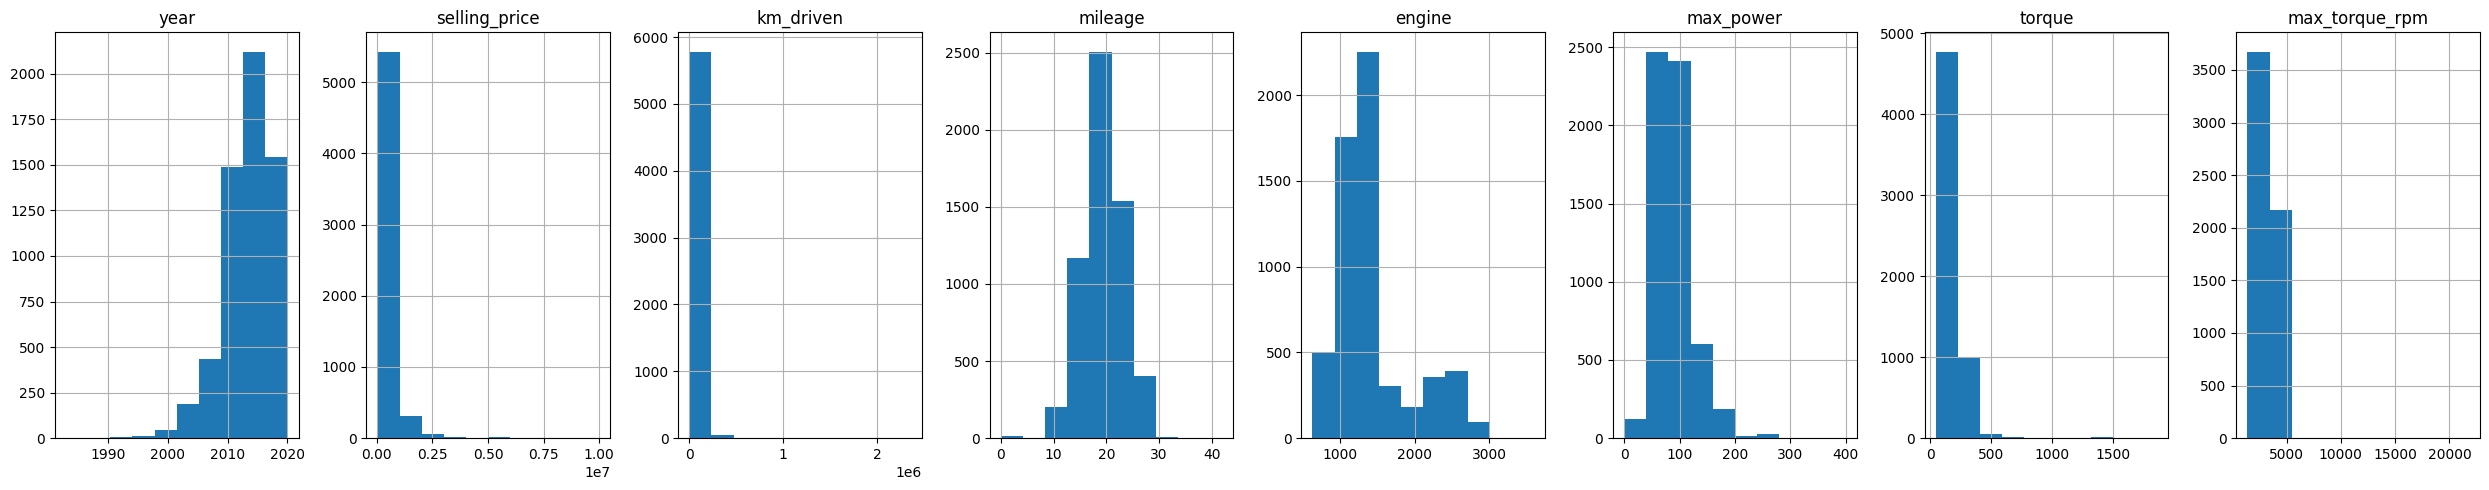

In [123]:
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_columns), figsize=(25, 5))
for idx, col in enumerate(numeric_columns):
    df_train[col].hist(ax=axes[idx])
    axes[idx].set_title(col)
plt.tight_layout()

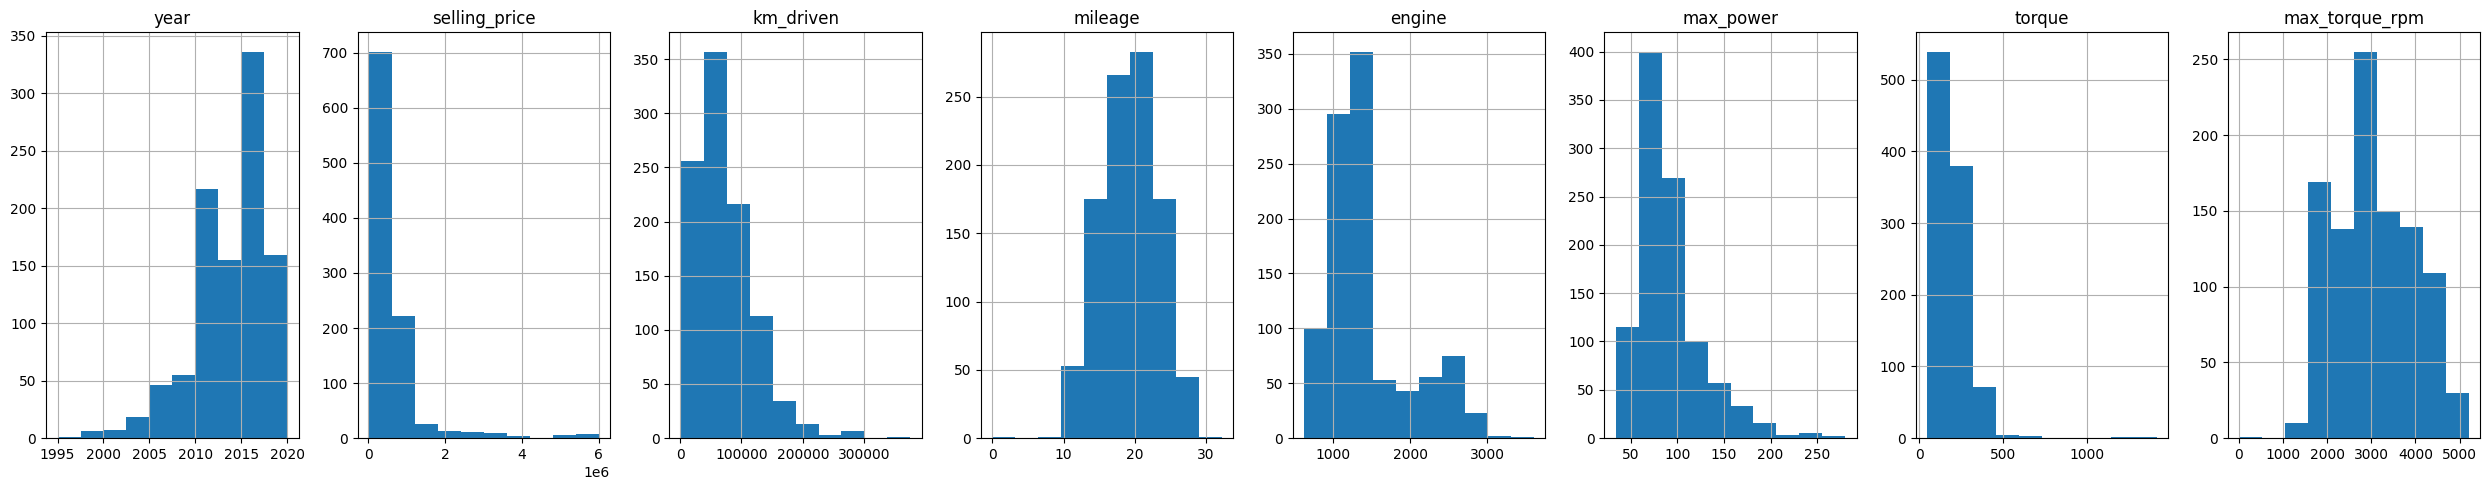

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_columns), figsize=(25, 5))
for idx, col in enumerate(numeric_columns):
    df_test[col].hist(ax=axes[idx])
    axes[idx].set_title(col)
plt.tight_layout()

Как можно заметить из графиков, у многих числовых признаков (включая целевой) распределение не особо похоже на нормальное. В рамках данной главы давайте попробуем прологарифмировать целевой признак и посмотрим, изменит ли это что-нибудь в нашей модели.

Дополнительно будем использовать обработку категориальных фичей. Еще думаю, что правильно было бы внести `year` в их число, так как здесь этот признак выступает как порядковая переменная.

In [125]:
df_train_log = deepcopy(df_train)
df_test_log = deepcopy(df_test)

y_train = df_train_log["selling_price"]
y_test = df_test_log["selling_price"]

df_train_log.loc[:, "selling_price"] = np.log(df_train_log["selling_price"])
df_test_log.loc[:, "selling_price"] = np.log(df_test_log["selling_price"])

In [126]:
X_train = df_train_log.drop(columns=["selling_price", "name"])
X_test = df_test_log.drop(columns=["selling_price", "name"])

y_train_log = df_train_log["selling_price"]
y_test_log = df_test_log["selling_price"]

In [127]:
encoder = OneHotEncoder(drop="first", sparse=False)
X_train_cat = encoder.fit_transform(
    X_train[["year", "fuel", "seller_type", "transmission", "owner", "seats"]]
)
X_test_cat = encoder.transform(
    X_test[["year", "fuel", "seller_type", "transmission", "owner", "seats"]]
)

In [128]:
robust_scaler = RobustScaler()
X_train = X_train.drop(
    columns=["year", "fuel", "seller_type", "transmission", "owner", "seats"]
)
X_test = X_test.drop(
    columns=["year", "fuel", "seller_type", "transmission", "owner", "seats"]
)

X_train = robust_scaler.fit_transform(X_train)
X_test = robust_scaler.transform(X_test)

In [129]:
X_train = np.concatenate([X_train, X_train_cat], axis=1)
X_test = np.concatenate([X_test, X_test_cat], axis=1)

In [130]:
param_grid = {"alpha": [0.001, 0.01, 0.1, 0.5, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), param_grid, cv=10, scoring="r2")

In [131]:
ridge_grid.fit(X_train, y_train_log)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10, 100]},
             scoring='r2')

In [132]:
ridge_grid.best_params_

{'alpha': 0.1}

In [133]:
ridge_grid.best_estimator_.coef_

array([-0.00425002,  0.03493252,  0.07314313,  0.2860417 , -0.00718657,
       -0.03502373, -1.25153046, -0.65449543, -0.29192292, -0.580646  ,
       -0.57727826, -0.60350236, -0.72604598, -0.5536465 , -0.88173995,
       -0.55713379, -0.75366081, -0.65394829, -0.54073736, -0.3917066 ,
       -0.31921208, -0.19211129, -0.13348609,  0.02384274,  0.10598783,
        0.22556132,  0.39909089,  0.53570149,  0.69542871,  0.76778815,
        0.87577815,  0.99712799,  1.06925542,  0.94804489,  0.19320586,
        0.17498678,  0.05517305, -0.08799621,  0.03772251, -0.17270123,
       -0.13362663, -0.06902227,  0.81938644, -0.07705919, -0.24809386,
        0.03498997, -0.1232974 ,  0.07968214,  0.16935805,  0.03250207,
       -0.05768762, -0.17420209])

In [134]:
r_train_ridge = r2_score(y_train_log, ridge_grid.best_estimator_.predict(X_train))
r_test_ridge = r2_score(y_test_log, ridge_grid.best_estimator_.predict(X_test))
r_test_rmse = mean_squared_error(
    y_test_log, ridge_grid.best_estimator_.predict(X_test), squared=False
)
print(
    f"R\N{SUPERSCRIPT TWO} оценка на обучении составила: " f"{round(r_train_ridge, 4)}"
)
print(f"R\N{SUPERSCRIPT TWO} оценка на тесте составила: " f"{round(r_test_ridge, 4)}")
print(f"RMSE на тесте составила: " f"{round(r_test_rmse, 4)}")

R² оценка на обучении составила: 0.8531
R² оценка на тесте составила: 0.8739
RMSE на тесте составила: 0.3003


Вот это результат! Мало того, что гораздо увеличили итоговый скор на тесте, так даже превзошли скор на обучении. Больше того, теперь у нас совсем иные коэффициенты - никаких 930 тысяч уже нет, что не может не радовать. 

Теперь остается одна __проблема__: наш целевой признак прологарифмирован и его нужно вернуть к исходному значению. Можно посмотреть, как изменится оценка $R^2$ после такого преобразования.

In [135]:
r_train_ridge = r2_score(y_train, np.exp(ridge_grid.best_estimator_.predict(X_train)))
r_test_ridge = r2_score(y_test, np.exp(ridge_grid.best_estimator_.predict(X_test)))
r_test_rmse = mean_squared_error(
    y_test, np.exp(ridge_grid.best_estimator_.predict(X_test)), squared=False
)
print(
    f"R\N{SUPERSCRIPT TWO} оценка на обучении составила: " f"{round(r_train_ridge, 4)}"
)
print(f"R\N{SUPERSCRIPT TWO} оценка на тесте составила: " f"{round(r_test_ridge, 4)}")
print(f"RMSE на тесте составила: " f"{round(r_test_rmse, 4)}")

R² оценка на обучении составила: 0.836
R² оценка на тесте составила: 0.8182
RMSE на тесте составила: 323294.8076


Оценка на тесте упала, но, думаю, что итоговые значения отражают истинные способности модели: все-таки для нас важна настоящая цена машины, а не ее логарифм.

## Использование признака `name`

До этого момента мы не использовали этот признак при обучении модели. Быть может, он дал бы какой-никакой, но прирост в качестве.

Посмотрим, что нам даст использование наименование бренда автомобиля.

_Функция для более удобного обучения на будущее_

In [136]:
def train_logreg_with_log_target(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    cat_columns: list,
    estimator,
    param_grid: dict,
    cv: int = 10,
    use_polynomial_features: bool = False,
    count_polynomial: int = 2,
):

    X_train = df_train.drop(columns=["selling_price"])
    X_test = df_test.drop(columns=["selling_price"])

    y_train = df_train["selling_price"]
    y_test = df_test["selling_price"]

    y_train_log = np.log(df_train["selling_price"])

    encoder = OneHotEncoder(
        drop="first", sparse=False, handle_unknown="infrequent_if_exist"
    )
    with warnings.catch_warnings(category=UserWarning):
        warnings.simplefilter("ignore")
        X_train_cat = encoder.fit_transform(X_train[cat_columns])
        X_test_cat = encoder.transform(X_test[cat_columns])

    robust_scaler = RobustScaler()
    X_train = X_train.drop(columns=cat_columns)
    X_test = X_test.drop(columns=cat_columns)

    if use_polynomial_features:
        polynomial_features = PolynomialFeatures(
            degree=count_polynomial, include_bias=False
        )
        X_train = polynomial_features.fit_transform(X_train)
        X_test = polynomial_features.transform(X_test)

    X_train = robust_scaler.fit_transform(X_train)
    X_test = robust_scaler.transform(X_test)

    X_train = np.concatenate([X_train, X_train_cat], axis=1)
    X_test = np.concatenate([X_test, X_test_cat], axis=1)

    ridge_grid = GridSearchCV(estimator, param_grid, cv=cv, scoring="r2")
    ridge_grid.fit(X_train, y_train_log)

    r_train_ridge = r2_score(
        y_train, np.exp(ridge_grid.best_estimator_.predict(X_train))
    )
    r_test_ridge = r2_score(y_test, np.exp(ridge_grid.best_estimator_.predict(X_test)))
    r_test_mse = mean_squared_error(
        y_test, np.exp(ridge_grid.best_estimator_.predict(X_test)), squared=False
    )
    print(
        f"R\N{SUPERSCRIPT TWO} оценка на обучении составила: "
        f"{round(r_train_ridge, 4)}"
    )
    print(
        f"R\N{SUPERSCRIPT TWO} оценка на тесте составила: " f"{round(r_test_ridge, 4)}"
    )
    print(f"RMSE на тесте: {round(r_test_mse, 4)}")

    return ridge_grid, X_train, X_test

In [137]:
df_train_name = deepcopy(df_train)
df_test_name = deepcopy(df_test)

df_train_name.loc[:, "name"] = df_train_name["name"].astype("str").str.split(" ").str[0]
df_test_name.loc[:, "name"] = df_test_name["name"].astype("str").str.split(" ").str[0]

In [138]:
cat_columns = ["name", "year", "fuel", "seller_type", "transmission", "owner", "seats"]

In [139]:
param_grid = {"alpha": [0.001, 0.01, 0.1, 0.5, 1, 10, 100]}

In [140]:
_ = train_logreg_with_log_target(
    df_train_name, df_test_name, cat_columns, Ridge(), param_grid
)

R² оценка на обучении составила: 0.9005
R² оценка на тесте составила: 0.9186
RMSE на тесте: 216308.229


Ничего себе, использование марки автомобиля уже заметно повысило качество модели! Отлично.

Попробуем расширить использование `name` и включить не только марку, но и модель автомобиля.

In [141]:
df_train_name = deepcopy(df_train)
df_test_name = deepcopy(df_test)

In [142]:
df_train_name.loc[:, "name"] = df_train_name["name"].astype("str").str.split(" ")
df_train_name.loc[:, "name"] = (
    df_train_name["name"].str[0] + " " + df_train_name["name"].str[1]
)
df_test_name.loc[:, "name"] = df_test_name["name"].astype("str").str.split(" ")
df_test_name.loc[:, "name"] = (
    df_test_name["name"].str[0] + " " + df_test_name["name"].str[1]
)

In [143]:
df_train_name.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Maruti Swift,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.00,5,2000
1,Skoda Rapid,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.00,5,2500
2,Hyundai i20,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,219.52,5,2750
3,Maruti Swift,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,112.70,5,4500
4,Hyundai Xcent,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,113.75,5,4000


In [144]:
_ = train_logreg_with_log_target(
    df_train_name, df_test_name, cat_columns, Ridge(), param_grid
)

R² оценка на обучении составила: 0.9317
R² оценка на тесте составила: 0.9129
RMSE на тесте: 223712.8139


Использование модели вместе с брендом не особо помогло, хотя и оценка на обучении теперь оказалась лучше.

In [145]:
df_train_name = deepcopy(df_train)
df_test_name = deepcopy(df_test)

In [146]:
df_train_name.loc[:, "name"] = df_train_name["name"].astype("str").str.split(" ")
df_train_name["model"] = df_train_name["name"].str[1]
df_train_name.loc[:, "name"] = df_train_name["name"].str[0]

df_test_name.loc[:, "name"] = df_test_name["name"].astype("str").str.split(" ")
df_test_name["model"] = df_test_name["name"].str[1]
df_test_name.loc[:, "name"] = df_test_name["name"].str[0]

In [147]:
df_train_name.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm,model
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.00,5,2000,Swift
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.00,5,2500,Rapid
2,Hyundai,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,219.52,5,2750,i20
3,Maruti,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,112.70,5,4500,Swift
4,Hyundai,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,113.75,5,4000,Xcent


In [148]:
cat_columns = [
    "name",
    "year",
    "fuel",
    "seller_type",
    "transmission",
    "owner",
    "seats",
    "model",
]

In [149]:
_ = train_logreg_with_log_target(
    df_train_name, df_test_name, cat_columns, Ridge(), param_grid
)

R² оценка на обучении составила: 0.9473
R² оценка на тесте составила: 0.9468
RMSE на тесте: 174809.2929


А вот это уже другой разговор! Разделение столбца `name` на бренд автомобиля и модель дало хорошие результаты, очень даже хорошие!

Напоследок, для итогового результата воспользуемся библиотекой `Optuna`.

In [150]:
def objective(trial, df_train_name, df_test_name):
    X_train = df_train_name.drop(columns=["selling_price"])
    X_test = df_test_name.drop(columns=["selling_price"])

    y_test = df_test_name["selling_price"]

    y_train_log = np.log(df_train_name["selling_price"])

    encoder = OneHotEncoder(
        drop="first", sparse=False, handle_unknown="infrequent_if_exist"
    )
    with warnings.catch_warnings(category=UserWarning):
        warnings.simplefilter("ignore")
        X_train_cat = encoder.fit_transform(X_train[cat_columns])
        X_test_cat = encoder.transform(X_test[cat_columns])

    robust_scaler = RobustScaler()
    X_train = X_train.drop(columns=cat_columns)
    X_test = X_test.drop(columns=cat_columns)

    X_train = robust_scaler.fit_transform(X_train)
    X_test = robust_scaler.transform(X_test)

    X_train = np.concatenate([X_train, X_train_cat], axis=1)
    X_test = np.concatenate([X_test, X_test_cat], axis=1)

    alpha = trial.suggest_float("alpha", 1e-10, 1e10, log=True)
    random_state = trial.suggest_int("random_state", 0, 240)
    solver = trial.suggest_categorical("solver", ["auto", "svd", "cholesky", "lsqr"])

    regressor = Ridge(alpha=alpha, solver=solver, random_state=random_state)

    regressor.fit(X_train, y_train_log)

    r_test_mse = mean_squared_error(
        y_test, np.exp(regressor.predict(X_test)), squared=False
    )

    return r_test_mse

In [151]:
study = optuna.create_study()
study.optimize(
    lambda trial: objective(trial, df_train_name, df_test_name), n_trials=1000
)

[I 2023-01-07 20:45:35,844] A new study created in memory with name: no-name-67ce980e-2261-409f-922e-0f99cbbff3c8
[I 2023-01-07 20:45:35,980] Trial 0 finished with value: 156626.35158217963 and parameters: {'alpha': 1.0971760826196307e-05, 'random_state': 10, 'solver': 'lsqr'}. Best is trial 0 with value: 156626.35158217963.
[I 2023-01-07 20:45:36,193] Trial 1 finished with value: 791975.0911655802 and parameters: {'alpha': 41621187.54006548, 'random_state': 131, 'solver': 'svd'}. Best is trial 0 with value: 156626.35158217963.
[I 2023-01-07 20:45:36,334] Trial 2 finished with value: 157326.0529724821 and parameters: {'alpha': 8.962140606340731e-10, 'random_state': 61, 'solver': 'svd'}. Best is trial 0 with value: 156626.35158217963.
[I 2023-01-07 20:45:36,464] Trial 3 finished with value: 193456.86953529305 and parameters: {'alpha': 0.9825323931111185, 'random_state': 15, 'solver': 'svd'}. Best is trial 0 with value: 156626.35158217963.
[I 2023-01-07 20:45:36,602] Trial 4 finished wit

In [152]:
study.best_trial

FrozenTrial(number=963, values=[156594.9544275737], datetime_start=datetime.datetime(2023, 1, 7, 20, 48, 22, 127284), datetime_complete=datetime.datetime(2023, 1, 7, 20, 48, 22, 277352), params={'alpha': 0.011260503635488917, 'random_state': 180, 'solver': 'lsqr'}, distributions={'alpha': LogUniformDistribution(high=10000000000.0, low=1e-10), 'random_state': IntUniformDistribution(high=240, low=0, step=1), 'solver': CategoricalDistribution(choices=('auto', 'svd', 'cholesky', 'lsqr'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=963, state=TrialState.COMPLETE, value=None)

Удалось еще немного улучшить итоговый результат для более удачного применения модели в проде.

## Подводя итоги и закрепляя результат

Хотелось бы попробовать еще несколько экспериментов, не выводя их в отдельные главы.

__Полиномиальные фичи__

In [154]:
_ = train_logreg_with_log_target(
    df_train_name,
    df_test_name,
    cat_columns,
    Ridge(),
    {
        "solver": [study.best_params["solver"]],
        "alpha": [study.best_params["alpha"]],
    },
    use_polynomial_features=True,
    count_polynomial=2,
)

R² оценка на обучении составила: 0.9533
R² оценка на тесте составила: 0.9457
RMSE на тесте: 176726.0968


In [155]:
_ = train_logreg_with_log_target(
    df_train_name,
    df_test_name,
    cat_columns,
    Ridge(),
    {
        "solver": [study.best_params["solver"]],
        "alpha": [study.best_params["alpha"]],
    },
    use_polynomial_features=True,
    count_polynomial=3,
)

R² оценка на обучении составила: 0.8991
R² оценка на тесте составила: 0.9365
RMSE на тесте: 191030.367


__Доп. фича на основе пробега и кол-ва владельцев__

In [156]:
df_train_copy = deepcopy(df_train_name)
df_test_copy = deepcopy(df_test_name)

In [157]:
df_train_copy["quality"] = 0
quality_cars_train = df_train_copy[
    (df_train_copy["owner"] == "First Owner") & (df_train_copy["km_driven"] < 50_000)
]
df_train_copy.loc[quality_cars_train.index, "quality"] = 1

In [158]:
df_test_copy["quality"] = 0
quality_cars_test = df_test_copy[
    (df_test_copy["owner"] == "First Owner") & (df_test_copy["km_driven"] < 50_000)
]
df_test_copy.loc[quality_cars_test.index, "quality"] = 1

In [159]:
cat_columns_for_add_features = deepcopy(cat_columns)
cat_columns_for_add_features.append("quality")

In [160]:
_ = train_logreg_with_log_target(
    df_train_copy,
    df_test_copy,
    cat_columns_for_add_features,
    Ridge(),
    {
        "solver": [study.best_params["solver"]],
        "alpha": [study.best_params["alpha"]],
    },
)

R² оценка на обучении составила: 0.9566
R² оценка на тесте составила: 0.9566
RMSE на тесте: 157980.3782


Что ж, остановимся на достигнутом.

В итоге, выстрелили две составляющие - логарифмирование целевой переменной `selling_price` и использование признака `name`. Дополнительно при помощи _Optuna_ удалось подобрать более лучшие параметры для модели.

Стоит сделать пайплайн для более удобного использования модели в дальнейшем.

Пайплайн для обучения и инференса модели был прописан в отдельном py-файле под названием __pipeline.py__.

In [161]:
from pipeline import Pipeline

In [162]:
final_model = Pipeline(
    train_path=(
        "https://raw.githubusercontent.com/Murcha1990/"
        "MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv"
    ),
    test_path=(
        "https://raw.githubusercontent.com/Murcha1990/"
        "MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv"
    ),
    categorical_cols=[
        "name",
        "year",
        "fuel",
        "seller_type",
        "transmission",
        "owner",
        "seats",
        "model",
    ],
    numeric_cols_w_nan=[
        "mileage",
        "engine",
        "max_power",
        "torque",
        "seats",
        "max_torque_rpm",
    ],
    alpha_start=1e-10,
    alpha_end=1e10,
    random_state_start=0,
    random_state_end=240,
    solvers=["auto", "svd", "cholesky", "lsqr"],
    number_of_trials=1000,
    save_path="saved_models",
    cv=10,
)

In [163]:
final_model.preprocess_datasets()

In [164]:
final_model.train_model()

In [165]:
test_scores, cv_scores = final_model.evaluate_model()

In [166]:
final_model.save_model()

In [167]:
test_scores

{'R2_score_train': 0.9804412969414051,
 'R2_score_test': 0.9616218058762752,
 'RMSE_score_train': 113124.41232441705,
 'RMSE_score_test': 148529.06077987753}

In [168]:
cv_scores

{'R2_score_0': 0.9757302146848783,
 'RMSE_score_0': 114067.49459898061,
 'R2_score_1': 0.9627422403112502,
 'RMSE_score_1': 142092.07780199926,
 'R2_score_2': 0.9817098458342646,
 'RMSE_score_2': 110970.0064456947,
 'R2_score_3': 0.9790022109346244,
 'RMSE_score_3': 121048.05519367503,
 'R2_score_4': 0.9618604334694877,
 'RMSE_score_4': 151384.1330218037,
 'R2_score_5': 0.9771656146352271,
 'RMSE_score_5': 130844.32988421342,
 'R2_score_6': 0.9755252827084,
 'RMSE_score_6': 130923.24946433294,
 'R2_score_7': 0.9766094437289004,
 'RMSE_score_7': 125094.25189348096,
 'R2_score_8': 0.9371986284942618,
 'RMSE_score_8': 203028.40499742853,
 'R2_score_9': 0.9740836711545872,
 'RMSE_score_9': 135551.3977854484,
 'R2_score_mean': 0.9701627585955881,
 'RMSE_score_mean': 136500.34010870577}

# Часть Бизнесовая (0.5 балла)

Заказчик просил вас посчитать кастомную метрику -- среди всех предсказанных цен на авто посчитать долю предиктов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

<font color='#9933CC'>Сделайте это самостоятельно для лучшей из своих моделей</font>

In [169]:
def business_metrics(y_true: np.array, y_pred: np.array):
    y_true_10_perc = y_true * 0.1
    count_no_more = np.count_nonzero(np.abs(y_true - y_pred) <= y_true_10_perc)
    print(
        "Доля объектов с разницей между предсказанной и реальной ценой не более 10%: "
        f"{round(count_no_more / len(y_true), 4)}"
    )
    return count_no_more

In [170]:
print("Бизнес-метрика для обучающей выборки: ")
_ = business_metrics(
    final_model.y_train, np.exp(final_model.regressor.predict(final_model.X_train))
)

Бизнес-метрика для обучающей выборки: 
Доля объектов с разницей между предсказанной и реальной ценой не более 10%: 0.4775


In [171]:
print("Бизнес-метрика для тестовой выборки: ")
_ = business_metrics(
    final_model.y_test, np.exp(final_model.regressor.predict(final_model.X_test))
)

Бизнес-метрика для тестовой выборки: 
Доля объектов с разницей между предсказанной и реальной ценой не более 10%: 0.468


# Часть 5 (3 балла) | Реализация сервиса на FastAPI

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

In [172]:
from typing import List

from fastapi import FastAPI
from pydantic import BaseModel

app = FastAPI()


class Item(BaseModel):
    name: str
    year: int
    selling_price: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str
    engine: str
    max_power: str
    torque: str
    seats: float


class Items(BaseModel):
    objects: List[Item]


@app.post("/predict_item")
def predict_item(item: Item) -> float:
    return ...


@app.post("/predict_items")
def predict_items(items: List[Item]) -> List[float]:
    return ...

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# Часть 6 (1 балл) | Оформление результатов

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете прислать screencast в ТГ
3. Просматривает ноутбук с pure-DS частью
4. Заглядывает в код сервиса
5. Хвалит

# Часть Благодарственная

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

https://drive.google.com/file/d/1LT06nyg9QgVi3r-D5BY-_mQ9TcJQFxJN/view?usp=share_link